In [1]:
import sys 
import json
import os
from ast import literal_eval
from pathlib import Path 
import os

def readMinionStats(pathToFile):
    stats = open(pathToFile, "r")
    statTypeLoc = 0
    statValLoc = 1
    lines = stats.readlines()
    statsDict = {}
    for line in lines:
        line = line.split(":")
        if len(line) <= 1: 
            continue
        statsDict[line[statTypeLoc]] = literal_eval(line[statValLoc])
    return statsDict

def readMinizinc(pathToFile, statDict, solutionDict):
    miniStats = open(pathToFile, "r")
    lines = miniStats.readlines()
    statDict["timeout"] = False
    for line in lines:
        lineJson = json.loads(line)
        lineType = lineJson["type"]
        if lineType == "statistics":
            statDict.update(lineJson["statistics"])
            if "solveTime" in lineJson["statistics"] and lineJson["statistics"]["solveTime"] >= timeout_time:
                statDict["timeout"] = True
        elif lineType == "solution":
            solutionDict.update(lineJson["output"]["json"])
        elif lineType == "comment" and lineJson["comment"] == "% Time limit exceeded!":
            statDict["timeout"] = True
            
timeout_time = 3600

def fetch_data(statFile, isEprime, problemName=""):
    statInfo = {}
    if isEprime:
        # .info files
        statInfo = readMinionStats(statFile)
    else:
        miniSolution = {}
        readMinizinc(statFile, statInfo, miniSolution)
        # slashes = [i for i in range(len(statFile)) if statFile[i] == '/']
        # print(statFile + "/../../" +  + ".json")
        # with open(problemName + "/" + statFile[slashes[-1]+1:] + ".json", "w") as f:
        #     json.dump(miniSolution, f)
    return statInfo

In [2]:
import re
import statistics

dataLocation = "../instances_and_solutions/"

wordpress = "wordpress"
wordpressNoSymm = "wordpressNoSymm"
quasigroup = "quasigroup"
quasigroupOcc = "quasigroupOcc"
tournament = "tournament"
tournamentFree = "tournamentFree"
mspsp = "mspsp"
mspspNoStdLib = "mspspNoStdLib"
cvrptw = "cvrptw"
roster = "roster"
rosterFree = "rosterFree"


stdDevLoc = "stdDev"


# solvers = ["chuffed", "gecode"]
solvers = ["chuffed"]
problemFlags = ["noFree", "free"]

optimisations = ["O0_S0", "O2_S1", "O2_S2", "O3_S2"]
dataKeys = ["time", "solveTime", "initTime", "timeout"]
problemNames = [quasigroup, quasigroupOcc, wordpress, wordpressNoSymm, tournament, mspsp, mspspNoStdLib, cvrptw, roster]
noOccProblems = [quasigroup, wordpress, wordpressNoSymm, tournamentFree, tournament, mspsp, cvrptw, rosterFree, roster]
originalProblems = [quasigroup, wordpress, wordpressNoSymm, tournament, mspsp, cvrptw, roster]
freeOriginalProblems = [quasigroup, wordpress, wordpressNoSymm, tournamentFree, mspsp, cvrptw, rosterFree]

problems = []
for i in problemNames:
    for j in solvers:
        for k in problemFlags:
            problems.append(i + "_" + k + "_" + j)

freeProblems = [x for x in problems if "_free_" in x]
noFreeProblems = [x for x in problems if "_noFree_" in x]
chuffedProblems = [x for x in problems if "chuffed" in x]
gecodeProblems = [x for x in problems if "gecode" in x]

# print(problems)
# print(noFreeProblems)
# print(freeProblems)
# print(chuffedProblems)
# print(gecodeProblems)

eprimePath = "/eprime/"
minizincPath = "/minizinc/"

def extractNumbers(x):
    temp = re.findall(r'\d+', x)
    temp = list(map(int, temp))
    return temp[0]

def runVals(x, indx):
    return [i[indx] for i in x]

def getMedianStdev(runs):
    # sort runs by overall time
    sortedLst = sorted(runs, key=lambda x: x["time"])
    res = sortedLst[1].copy() # change here later!!!!!

    for key in dataKeys:
        if key != "timeout":
            res[key + "_stdev"] = statistics.stdev([rn[key] for rn in runs])
            # res[key + "_stdev"] = 0.5
    return res

def getData(path, isEprime):
    runs = []
    for entry in os.scandir(path):
        if os.path.isdir(entry):
            continue
        data = fetch_data(entry.path, isEprime)
        if isEprime:
            data = processEprime(data)
        # case of unknown message, ex. quasigroupOcc.mzn run on instance 50.json
        if not isEprime and 'time' not in data:
            # print(path, data)
            data["timeout"] = True
            data["initTime"] = 0.5 # dummy value
            data["time"] = timeoutTimeSecs
        
        # # CHANGE HERE LATER
        # if isEprime and "gecode" in path:
        #     data["timeout"] = True

        if data["timeout"]:
            data["solveTime"] = timeoutTimeSecs
            data["time"] = timeoutTimeSecs
        
        runs.append(data)

    if len(runs) > 0:
       return getMedianStdev(runs)
    #    if not isEprime:
    #         print(path, runs) 
    else:
        return {}

def processEprime(data):
    d = {}
    d["time"] = data['SolverTotalTime'] + data['SavileRowTotalTime']        
    d["solveTime"] = data['SolverTotalTime']
    d["initTime"] = data['SavileRowTotalTime']
    d["timeout"] = data['SolverTimeOut'] == 1
    # gecode does not give timeout
    if d["time"] >= timeoutTimeSecs:
        d["time"] = timeoutTimeSecs
        d["timeout"] = True
    return d

timeoutTimeSecs = 3600

# eprimeData[problemName_free/NoFree_chuffed/gecode][opt][(instanceName, values)]
eprimeData = {}
minizincData = {}

def extract_eprime(problemLocation, folder_name, problemIndex, solver, flag):
    opt = {}
    eprimeProblemLocation = problemLocation + eprimePath + folder_name +"/timing"
    if flag == "free" and solver == "chuffed":
        eprimeProblemLocation = problemLocation + eprimePath + "noFree_" + solver + "/timing"
    if "NoStdLib" in eprimeProblemLocation:
        eprimeProblemLocation = eprimeProblemLocation.replace("NoStdLib", "")
    for optimize in os.scandir(eprimeProblemLocation):
        if optimize.name == "infor":
            continue
        res = []
        for problem in os.scandir(optimize.path):
            res.append((problem.name, getData(problem.path, True)))
        opt[optimize.name] = res
    eprimeData[problemIndex] = opt

def extract_mzn(problemLocation, folder_name, problemIndex):
    res = []
    mzn_path_to_scan = problemLocation + minizincPath + folder_name
    if mspspNoStdLib in problemLocation:
        mzn_path_to_scan = dataLocation + "mspsp/minizinc/noStdLib/" + folder_name
    for problem in os.scandir(mzn_path_to_scan):
        if os.path.isdir(problem.path) and problem.name != "json":
            res.append((problem.name, getData(problem.path, False)))
    minizincData[problemIndex] = res

# def export_data():
#     # Serializing json
#     json_object = json.dumps(eprimeData, indent=4)
    
#     # Writing to data.json
#     with open("eprime_data.json", "w") as outfile:
#         outfile.write(json_object)


for i in problemNames:
    for flag in problemFlags:
        for solver in solvers:
            folder_name = flag + "_" + solver
            problemLocation = dataLocation + i 
            problemIndex = i + "_" + flag + "_" + solver
            extract_eprime(problemLocation, folder_name, problemIndex, solver, flag)
            extract_mzn(problemLocation, folder_name, problemIndex)

            
# export_data()
# print(minizincData)


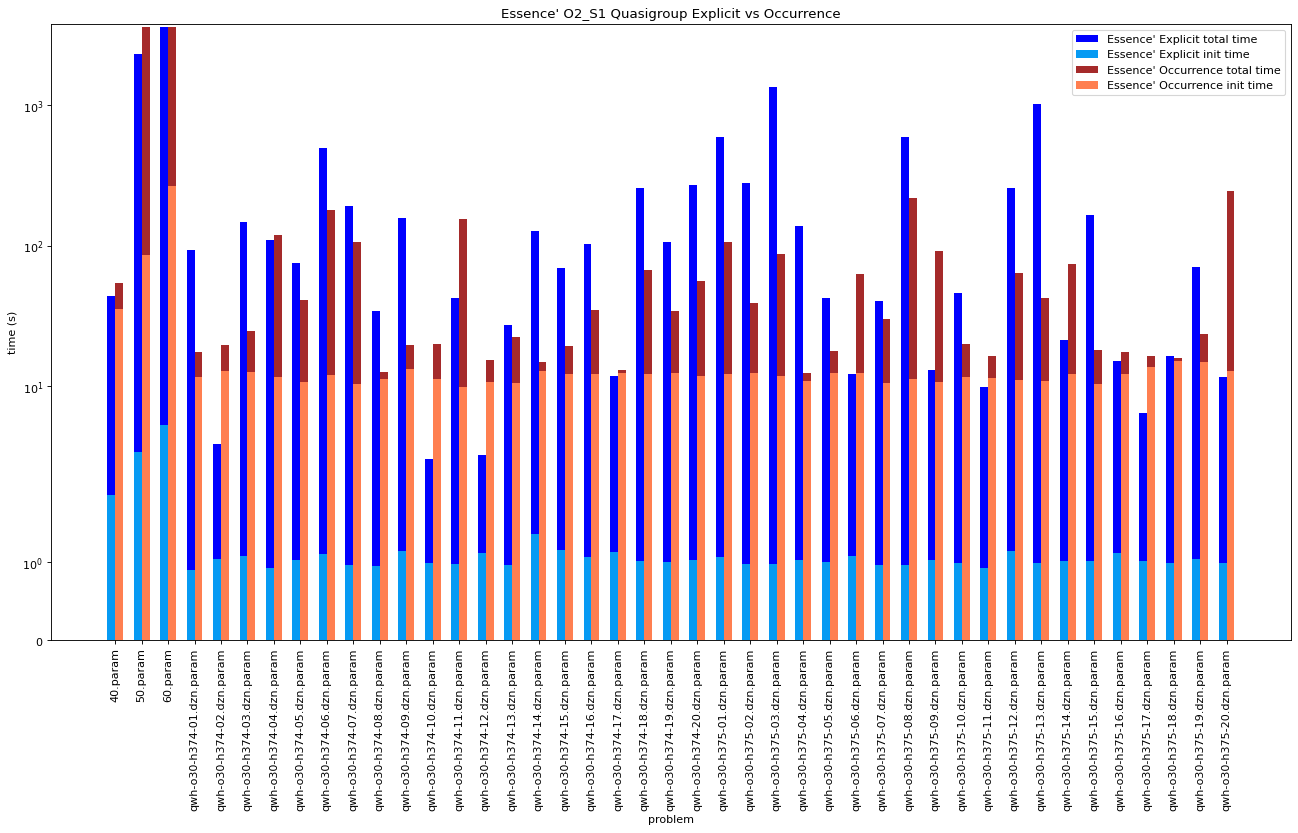

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

def getData(dataToExtract):
    xData, yData = zip(*sorted(dataToExtract))
    extractedY = []
    for i in dataKeys:
        extractedY.append(list(map(lambda y : y[i], yData)))
        if i != "timeout":
            extractedY.append(list(map(lambda y : y[i+"_stdev"], yData)))
    return (xData, *extractedY)



eprimeX, eprimeTime, eprimeTimeStdDev, eprimeSolverTime, eprimeSolverTimeStd, eprimeInit, eprimeInitStd, eprimeCompleted = getData(eprimeData["quasigroup_free_chuffed"]["O2_S1"])
minizincX, minizincTime, minizincTimeStd, minizincSolverTime, minizincSolverStd, minizincInit, mznInitStd, minizincCompleted = getData(eprimeData["quasigroupOcc_free_chuffed"]["O2_S1"])

# print(set(minizincX).difference(set(eprimeX)))
# print(set(eprimeX).difference(set(minizincX)))
# print(len(eprimeX))
# print(len(minizincX))

eprimeX = list(map(str, eprimeX))
minizincX = list(map(str, minizincX))

ind = np.arange(len(eprimeX))
width = 0.3

figure(figsize=(20, 10), dpi=80)
plt.title("Essence' O2_S1 Quasigroup Explicit vs Occurrence")
plt.bar(ind, eprimeTime, width, label="Essence' Explicit total time", color="blue")
plt.bar(ind, eprimeInit, width, label="Essence' Explicit init time",  color="#069AF3")
# plt.bar(ind+width, minizincTime, width, label="MiniZinc", color="red")
# plt.bar(ind+width, minizincInit, width, label="MiniZinc init time" , color="maroon")
plt.bar(ind+width, minizincTime, width, label="Essence' Occurrence total time", color="brown")
plt.bar(ind+width, minizincInit, width, label="Essence' Occurrence init time", color="coral")
# plt.scatter(eprimeX, eprimeY, label="eprime")
# plt.scatter(minizincX, minizincY, label="minizinc")
plt.legend(loc="best")
plt.xticks(ind+width/2, minizincX)
plt.xticks(rotation = 90)
plt.xlabel("problem")
plt.ylabel("time (s)")
plt.yscale("symlog")

In [4]:
import itertools

allEprimeTimings = {}
allMinizincTimings = {}

problemIndex = 0
timingIndex = 1
timingStdevIndex = 2
solverTimeIndex = 3
solverStdevIndex = 4
initIndex = 5
initIndexStdev = 6
timeoutIndex = 7

titleNames = {}
titleNames[timingIndex] = "total time"
titleNames[timingStdevIndex] = "total time standard deviation" 
titleNames[solverTimeIndex] = "solver time"
titleNames[solverStdevIndex] = "solver time standard deviation"
titleNames[initIndex] = "initialization time"
titleNames[initIndexStdev] = "initialization time standard deviation"
titleNames[timeoutIndex] = "timeout"

for i in problems:
    allMinizincTimings[i] = getData(minizincData[i])
    # print(minizincData[i])
    # print()
    allEprimeTimings[i] = {}
    for j in optimisations:
        allEprimeTimings[i][j] = getData(eprimeData[i][j])

# marker = itertools.cycle((',', '+', 'o', '*', '^', 'x', 's', 'v','2', 'd', 'H', 'X'))
marker = itertools.cycle(('v', 'o', 'P', 's'))
# color = itertools.cycle(('orange', 'red', 'black', 'green', 'blue', 'purple', 'grey', "brown", "gold", "darkslategray", "crimson", "forestgreen", "limegreen", "blueviolet", "darkorange", "teal", "orchid", "deepskyblue", "olivedrab", "sienna", "navy"))

maxLine = []

def setupPlotSolverSolver(graphTitle="Minizinc vs Essence'", indexOfInterest=timingIndex, plotTimeout=True):
    # fig = plt.figure(figsize=(20, 20), dpi=80)
    figure(figsize=(10, 10), dpi=80)
    # ax = plt.axes()
    if plotTimeout:
        plt.plot([0, timeoutTimeSecs], [0, timeoutTimeSecs])
    plt.xlabel("time MiniZinc (s)")
    plt.ylabel("time Essence' (s)")
    maxLine = []
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    plt.yscale("symlog")
    plt.xscale("symlog")
    plt.title(graphTitle + " " + titleNames[indexOfInterest])
    plt.rcParams['font.size'] = 14

# wordpress timingIndex, timing out
# tournament timingIndex, notably only 20f, 20h
# roster timingIndex, timing out
# cvrptw everything times out
# mspsp out-performed by minizinc on init and solver time
# quasigroup, all over the place

def createOccurencePlot(opt, occProblem, explicitProblem, annotate=False, indexOfInterest=timingIndex, errorbars=False):
    x, y = occProblem[indexOfInterest], explicitProblem[indexOfInterest]
    # chosenColor = next(color)
    plt.xlabel("time occurrence (s)")
    plt.ylabel("time explicit (s)")
    # plt.scatter(x, y, label= quasigroup + " " + opt, marker=next(marker), color=chosenColor)
    plt.scatter(x, y, label=quasigroup + " " + opt, marker=next(marker))
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    maxLine.extend(x)
    maxLine.extend(y)
    if annotate:
        for j in range(len(occProblem[problemIndex])):
            plt.annotate(occProblem[problemIndex][j], (occProblem[indexOfInterest][j], explicitProblem[indexOfInterest][j]))
    if errorbars:
        stdDevLoc = indexOfInterest+1
        # plt.errorbar(x, y, yerr=explicitProblem[stdDevLoc], xerr=occProblem[stdDevLoc], ls='none', color=chosenColor, lw=1)
        plt.errorbar(x, y, yerr=explicitProblem[stdDevLoc], xerr=occProblem[stdDevLoc], ls='none', lw=1)



def createPlot(opt, problemList, annotate=False, errorbars=False, indexOfInterest=timingIndex):
    for i in problemList:
        minizincProblem = allMinizincTimings[i]
        essenceProblem = allEprimeTimings[i][opt]
        # print(set(allMinizincTimings[i][problemIndex]).difference(set(allEprimeTimings[i][opt][problemIndex])))
        # print(set(allEprimeTimings[i][opt][problemIndex]).difference(set(allMinizincTimings[i][problemIndex])))
        x, y = minizincProblem[indexOfInterest], essenceProblem[indexOfInterest]
        maxLine.extend(x)
        maxLine.extend(y)
        # chosenColor = next(color)
        if errorbars:
            stdDevLoc = indexOfInterest+1
            plt.errorbar(x, y, yerr=essenceProblem[stdDevLoc], 
            xerr=minizincProblem[stdDevLoc], label= i + " " + opt, fmt=next(marker), ls='none', lw=0.5, capsize=2)
        else:
            plt.scatter(x, y, label= i + " " + opt, marker=next(marker))
        if annotate:
            for j in range(len(minizincProblem[problemIndex])):
                plt.annotate(minizincProblem[problemIndex][j], (minizincProblem[indexOfInterest][j], essenceProblem[indexOfInterest][j]))
        plt.xlim(left=0)
        plt.ylim(bottom=0)
    if len(problemList) == 1:
        plt.title("Minizinc vs Essence' " + problemList[0] + " " + titleNames[indexOfInterest])

# setupPlotSolverSolver()
# for j in optimisations:
#     createPlot(j, problems)

# box = plt.get_position()
# plt.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc="best")

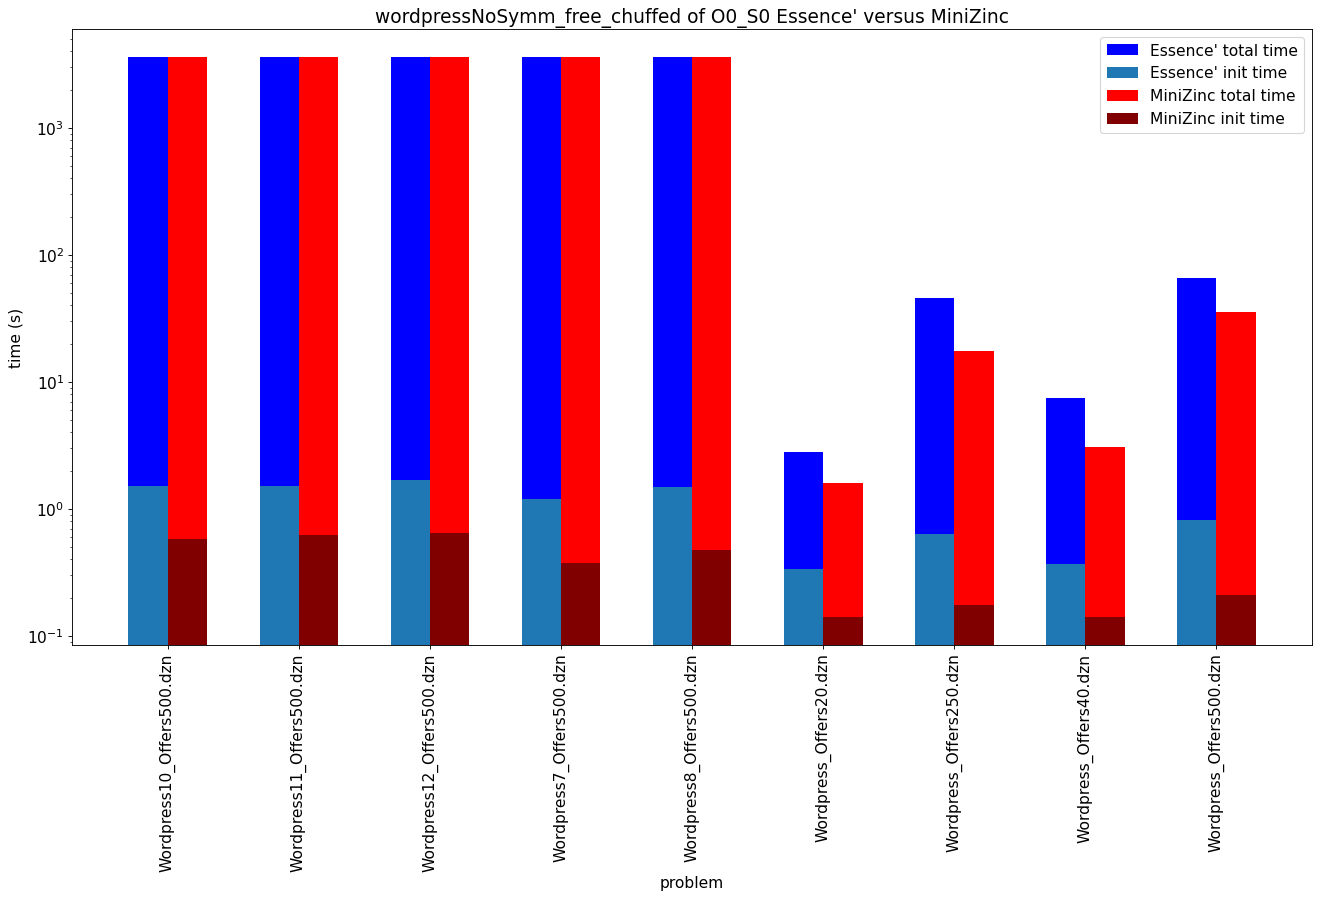

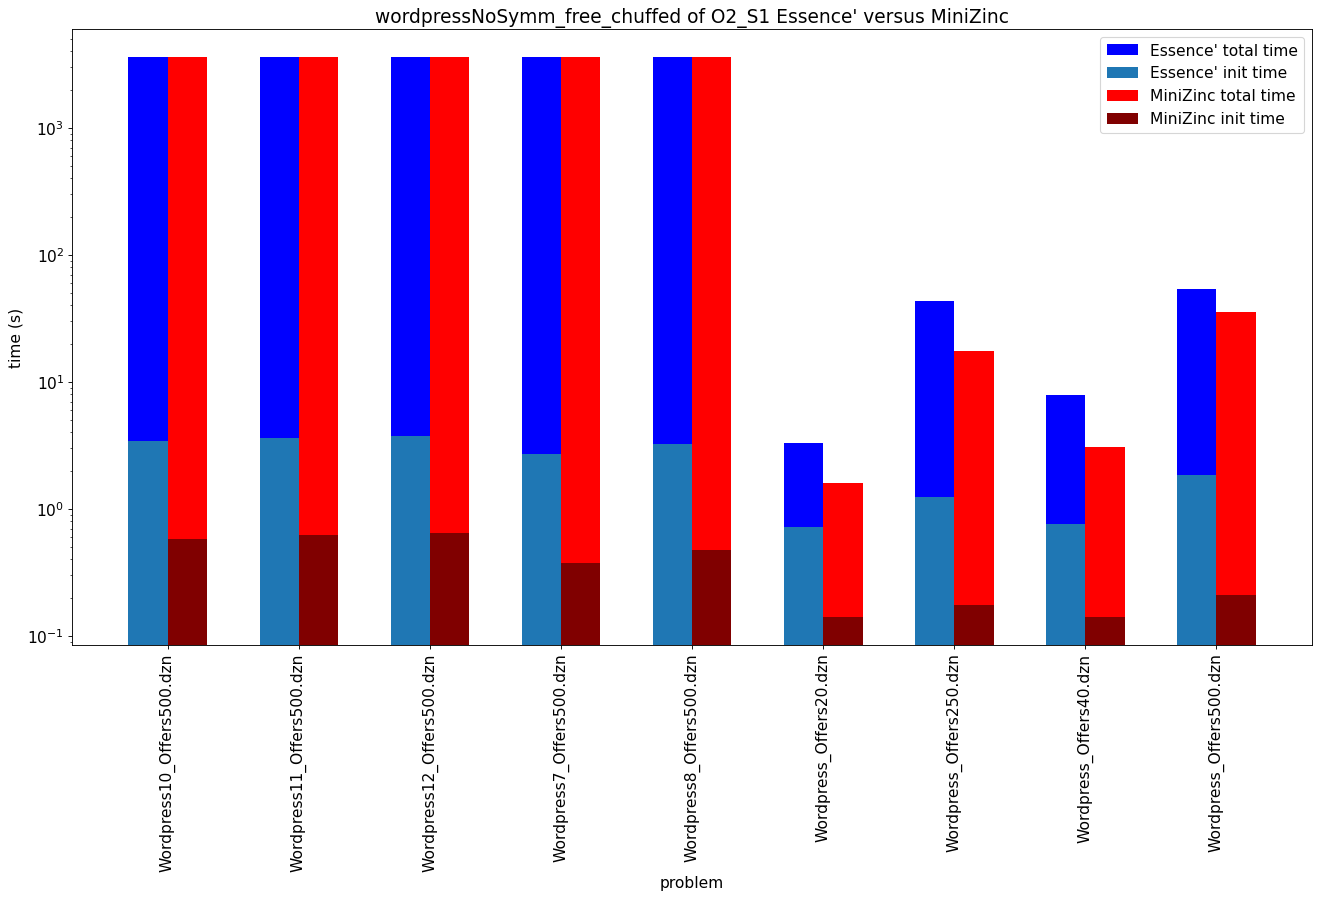

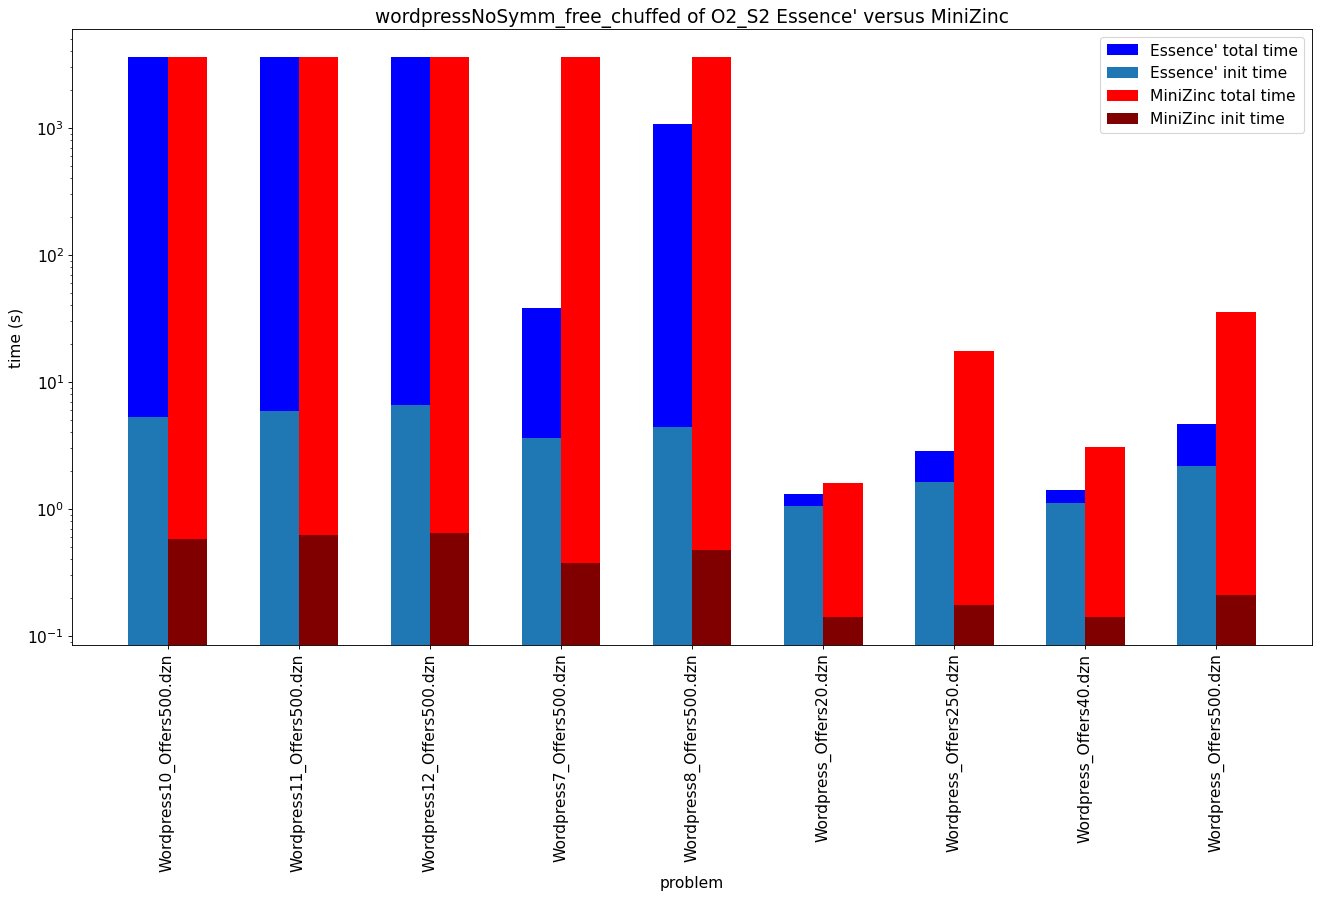

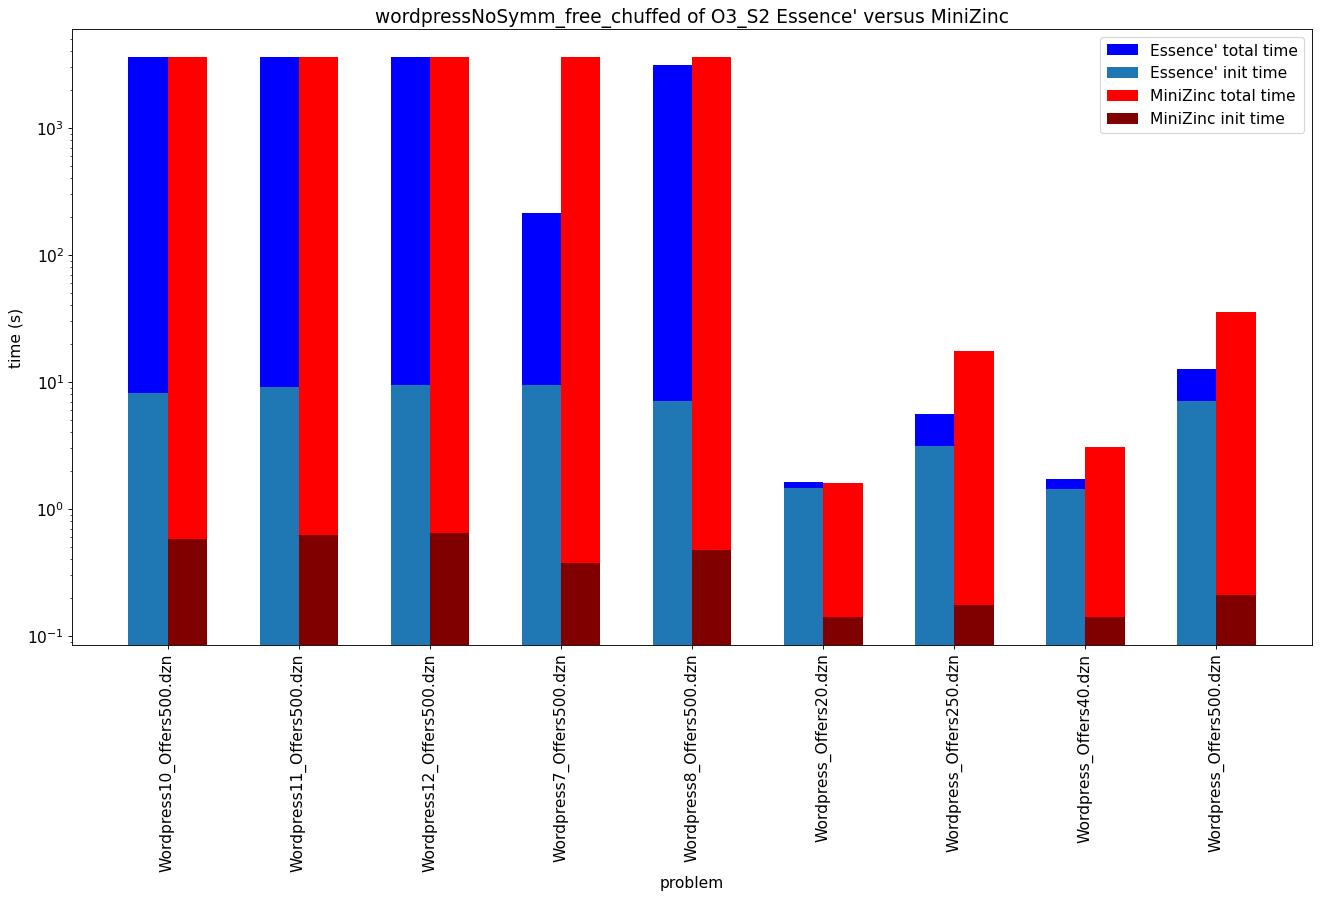

In [5]:

def createBarTimingsInit(opt, problem):
    ind = np.arange(len(allEprimeTimings[problem][opt][timingIndex]))
    width = 0.3
    figure(figsize=(20, 10), dpi=80)
    plt.rcParams['font.size'] = 14
    plt.bar(ind, allEprimeTimings[problem][opt][timingIndex], width, label="Essence' total time", color="blue")
    plt.bar(ind, allEprimeTimings[problem][opt][initIndex], width, label="Essence' init time")
    plt.bar(ind+width, allMinizincTimings[problem][timingIndex], width, label="MiniZinc total time", color="red")
    plt.bar(ind+width, allMinizincTimings[problem][initIndex], width, label="MiniZinc init time" , color="maroon")
    plt.legend(loc="best")
    plt.title(problem + " of " + opt + " Essence' versus MiniZinc")
    plt.xticks(ind+width/2, allMinizincTimings[problem][problemIndex])
    plt.xticks(rotation = 90)
    plt.xlabel("problem")
    plt.ylabel("time (s)")
    plt.yscale("log")

# for problem in chuffedProblems:
for problem in ["wordpressNoSymm_free_chuffed"]:
    for opt in optimisations:
        createBarTimingsInit(opt, problem)

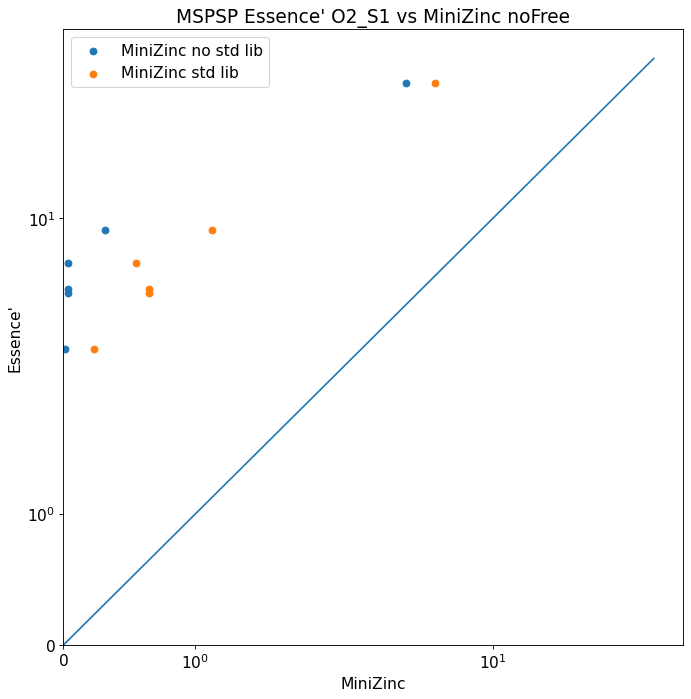

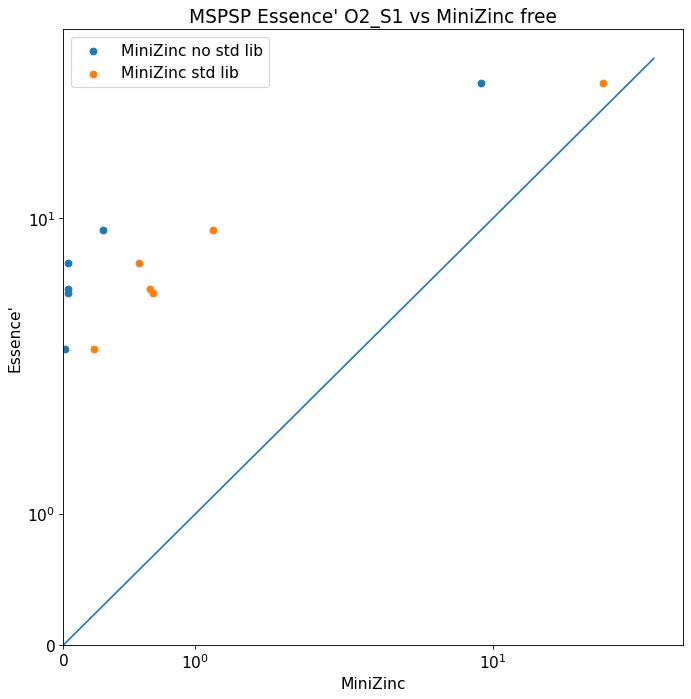

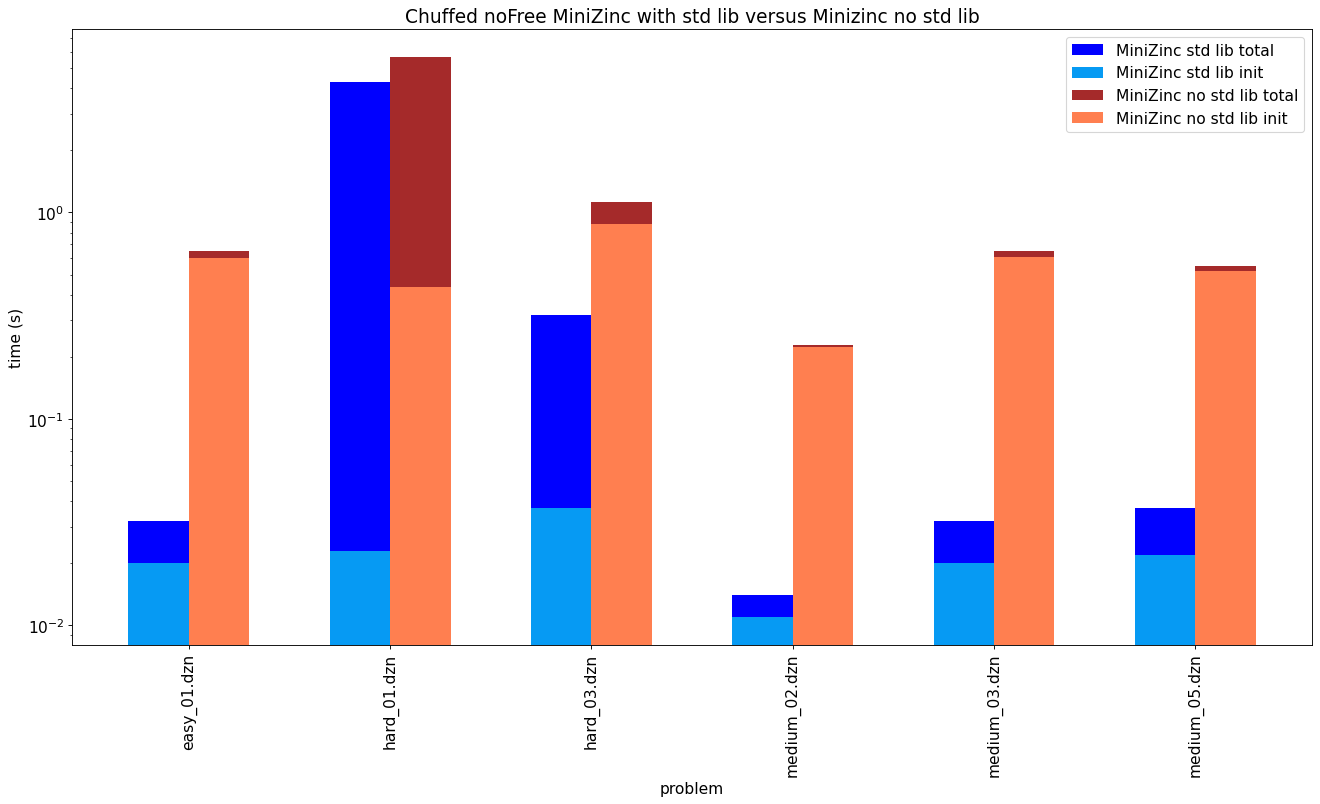

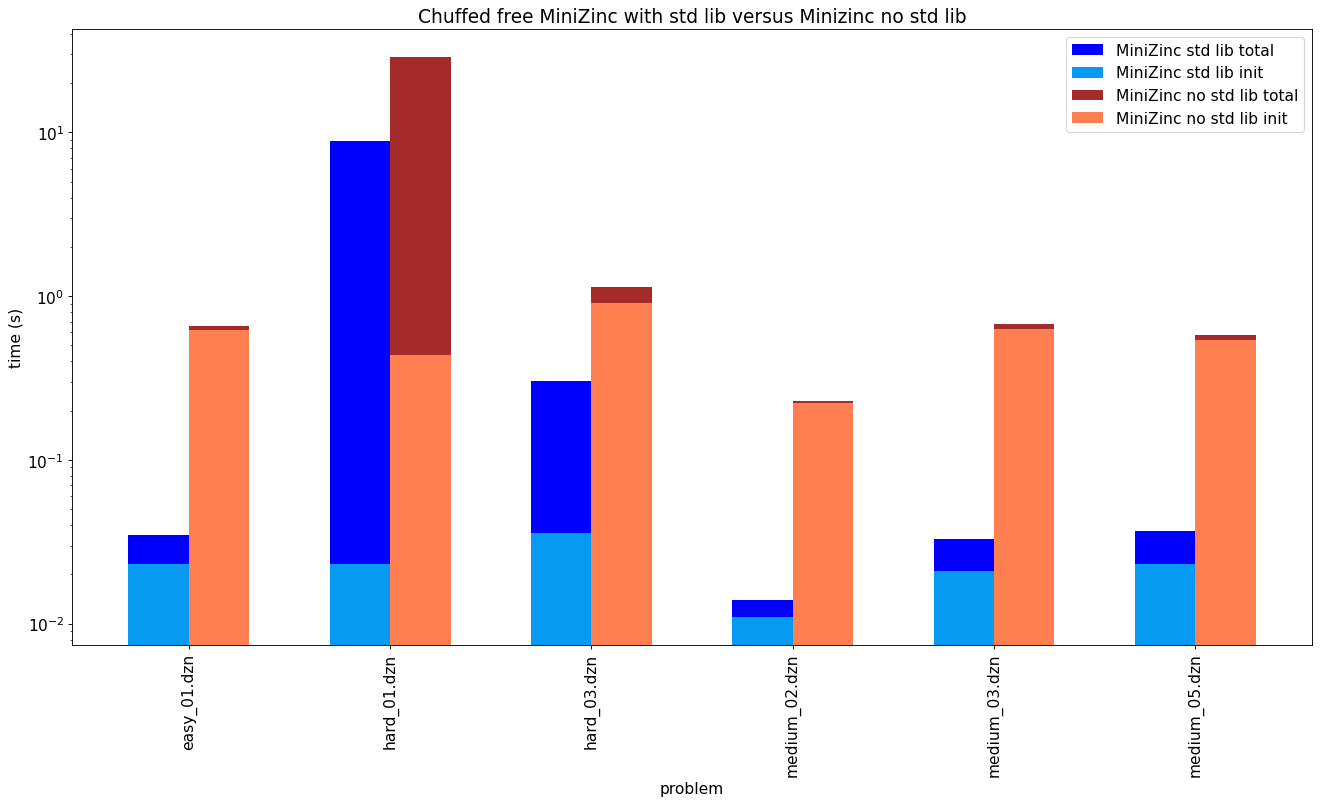

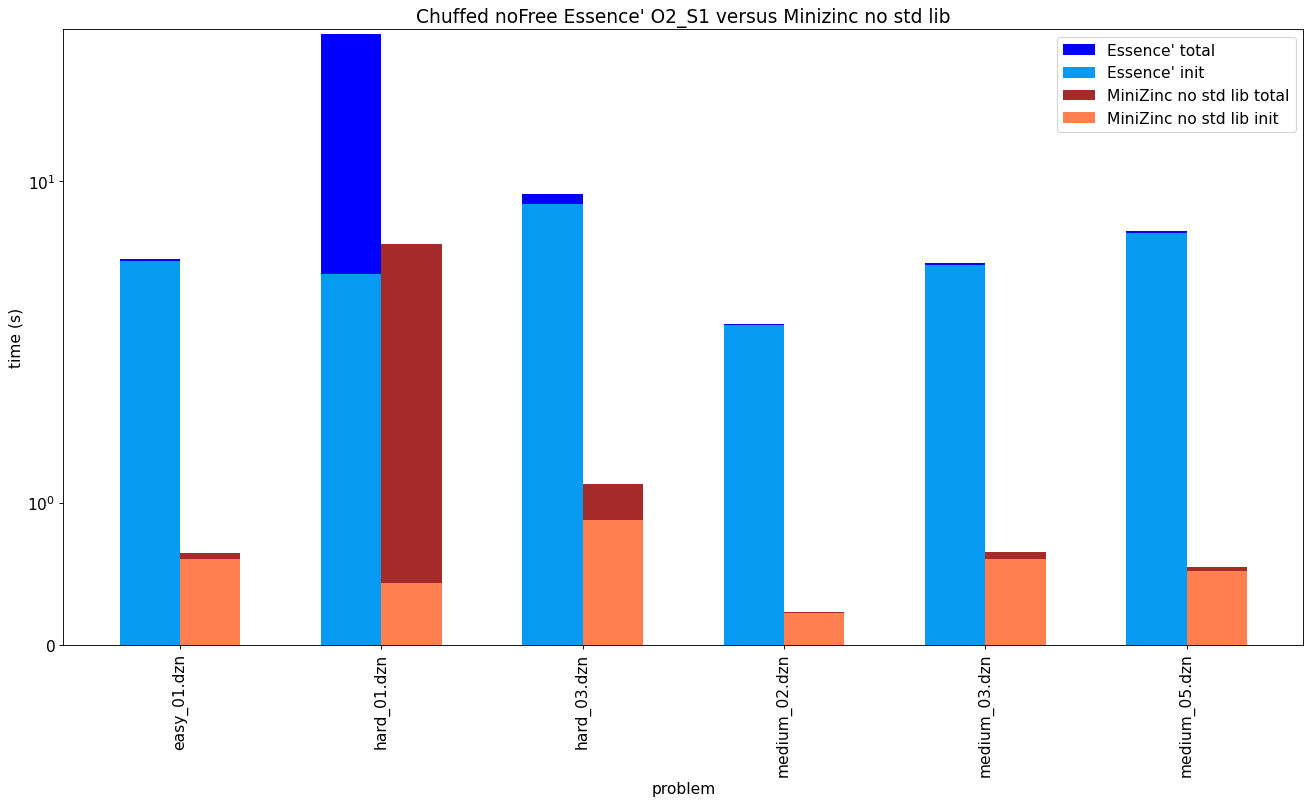

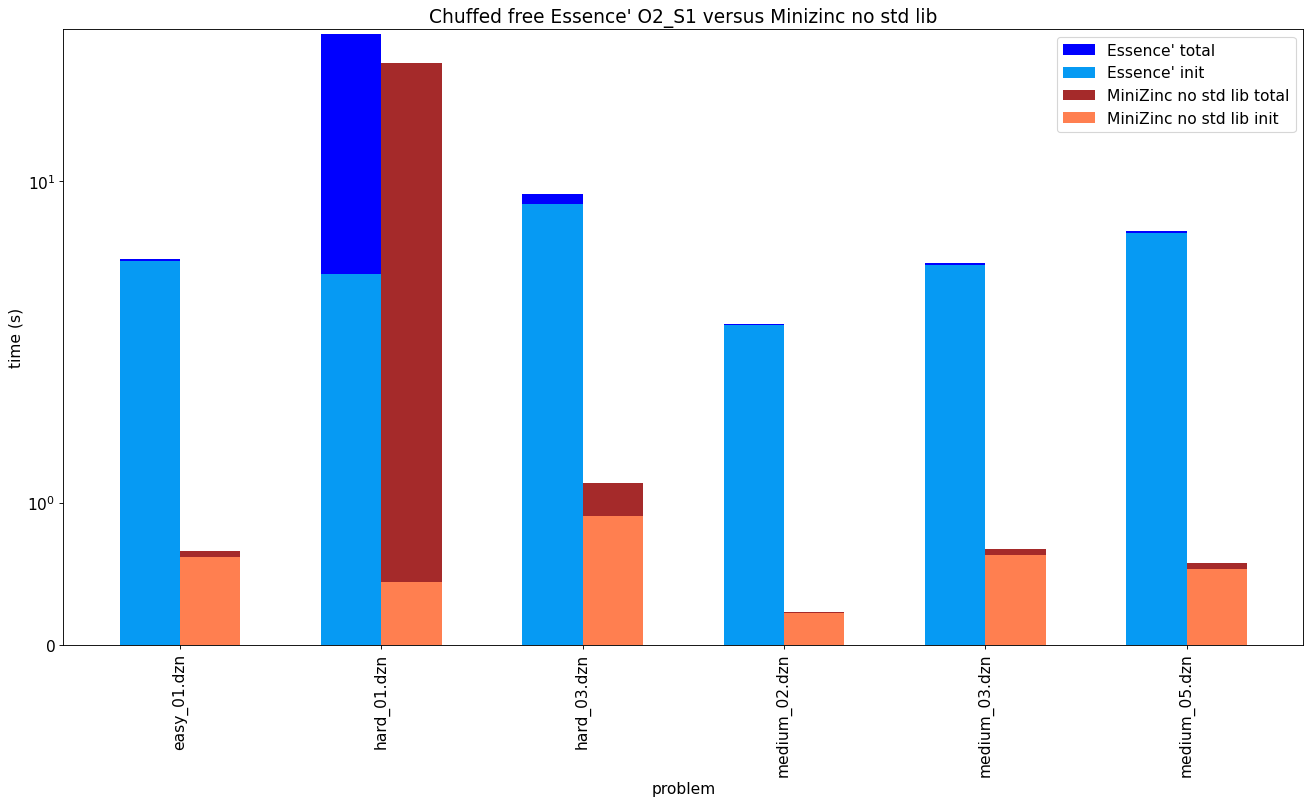

In [6]:
indx_of_interest=timingIndex

# for flag in problemFlags:
#     figure(figsize=(20, 10), dpi=80)
#     plt.xlabel("no std lib mzn")
#     plt.ylabel("std lib mzn")
#     plt.plot([0, timeoutTimeSecs], [0, timeoutTimeSecs])
#     plt.yscale("symlog")
#     plt.xscale("symlog")
#     plt.title("minizinc " + flag + " chuffed")
#     plt.scatter(allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][indx_of_interest], allMinizincTimings[mspsp + "_" + flag + "_chuffed"][indx_of_interest])

for opt in ["O2_S1"]:
    for flag in problemFlags:
        figure(figsize=(10, 10), dpi=80)
        plt.rcParams['font.size'] = 14
        plt.ylabel("Essence'")
        plt.xlabel("MiniZinc")
        plt.yscale("symlog")
        plt.xscale("symlog")
        plt.title("MSPSP Essence' " + opt  + " vs MiniZinc" + " " + flag)
        eprimeY = allEprimeTimings[mspspNoStdLib + "_" + flag + "_chuffed"][opt][indx_of_interest]
        minizincXNoStdLib = allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][indx_of_interest]
        minizincX = allMinizincTimings[mspsp + "_" + flag + "_chuffed"][indx_of_interest]
        maxLine = []
        maxLine.extend(eprimeY)
        maxLine.extend(minizincXNoStdLib)
        maxLine.extend(minizincX)
        end = max(maxLine)+10
        plt.scatter(minizincX, eprimeY, label="MiniZinc no std lib")
        plt.scatter(minizincXNoStdLib, eprimeY, label="MiniZinc std lib")
        # plt.plot([0,end], [0,0], color="black", linewidth=0.5)
        plt.plot([0,end],[0,end])
        plt.xlim(left=0)
        plt.ylim(bottom=0)
        plt.legend()
ind = np.arange(len(allEprimeTimings[problem][opt][timingIndex]))
width = 0.3


for flag in problemFlags:
    ind = np.arange(len(allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][timingIndex]))
    width = 0.3
    figure(figsize=(20, 10), dpi=80)
    plt.rcParams['font.size'] = 14
    plt.bar(ind, allMinizincTimings[mspsp + "_" + flag + "_chuffed"][timingIndex], width, label="MiniZinc std lib total", color="blue")
    plt.bar(ind, allMinizincTimings[mspsp + "_" + flag + "_chuffed"][initIndex], width, label="MiniZinc std lib init", color="#069AF3")
    plt.bar(ind+width, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][timingIndex], width, label="MiniZinc no std lib total", color="brown")
    plt.bar(ind+width, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][initIndex], width, label="MiniZinc no std lib init" , color="coral")
    plt.legend(loc="best")
    plt.title("Chuffed " + flag + " MiniZinc with std lib versus Minizinc no std lib")
    plt.xticks(ind+width/2, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][problemIndex])
    plt.xticks(rotation = 90)
    # plt.xticks(ind+width/2, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][timingIndex])
    plt.xticks(rotation = 90)
    plt.xlabel("problem")
    plt.ylabel("time (s)")
    plt.yscale("log")

for flag in problemFlags:
    ind = np.arange(len(allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][timingIndex]))
    width = 0.3
    figure(figsize=(20, 10), dpi=80)
    plt.rcParams['font.size'] = 14
    plt.bar(ind, allEprimeTimings[mspsp + "_" + flag + "_chuffed"]["O2_S1"][timingIndex], width, label="Essence' total", color="blue")
    plt.bar(ind, allEprimeTimings[mspsp + "_" + flag + "_chuffed"]["O2_S1"][initIndex], width, label="Essence' init", color="#069AF3")
    plt.bar(ind+width, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][timingIndex], width, label="MiniZinc no std lib total", color="brown")
    plt.bar(ind+width, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][initIndex], width, label="MiniZinc no std lib init", color="coral")
    plt.legend(loc="best")
    plt.title("Chuffed " + flag + " Essence' O2_S1 versus Minizinc no std lib")
    plt.xticks(ind+width/2, allMinizincTimings[mspspNoStdLib + "_" + flag + "_chuffed"][problemIndex])
    plt.xticks(rotation = 90)
    plt.xlabel("problem")
    plt.ylabel("time (s)")
    plt.yscale("symlog")

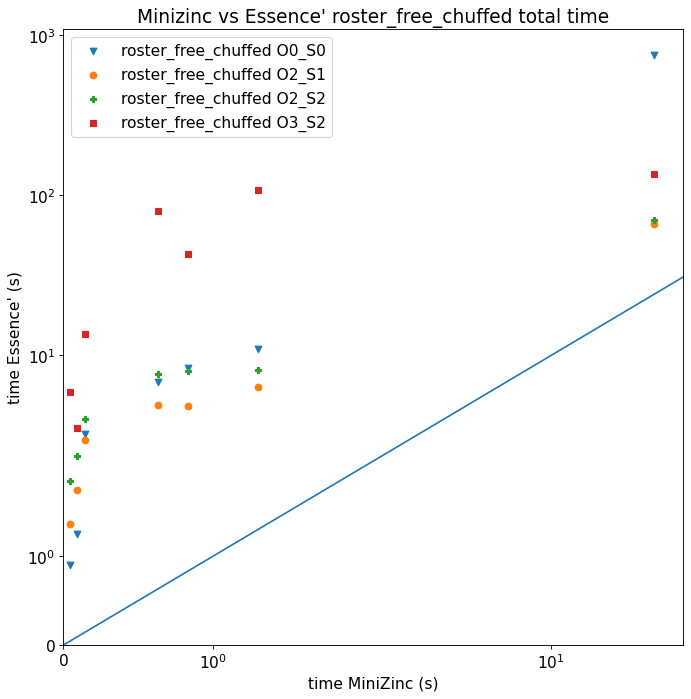

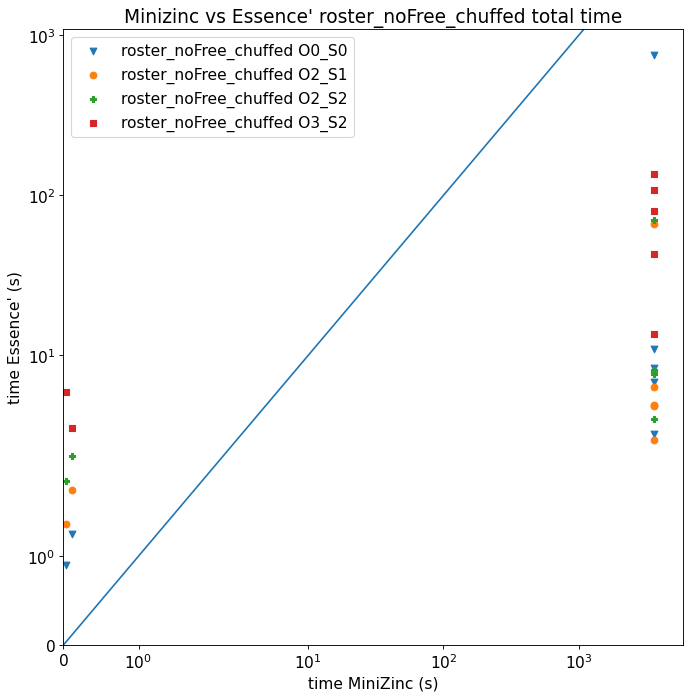

In [7]:
for p in ["roster_free_chuffed", "roster_noFree_chuffed"]:
    setupPlotSolverSolver(plotTimeout=False)
    for j in optimisations:
        createPlot(j, [p])
    plt.legend(loc="best")
    end = [0, max(maxLine)]
    plt.plot(end, end)

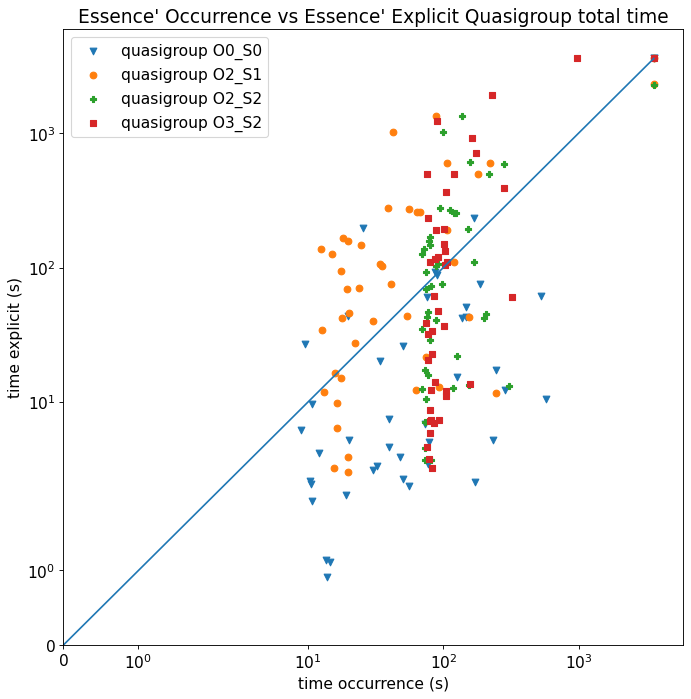

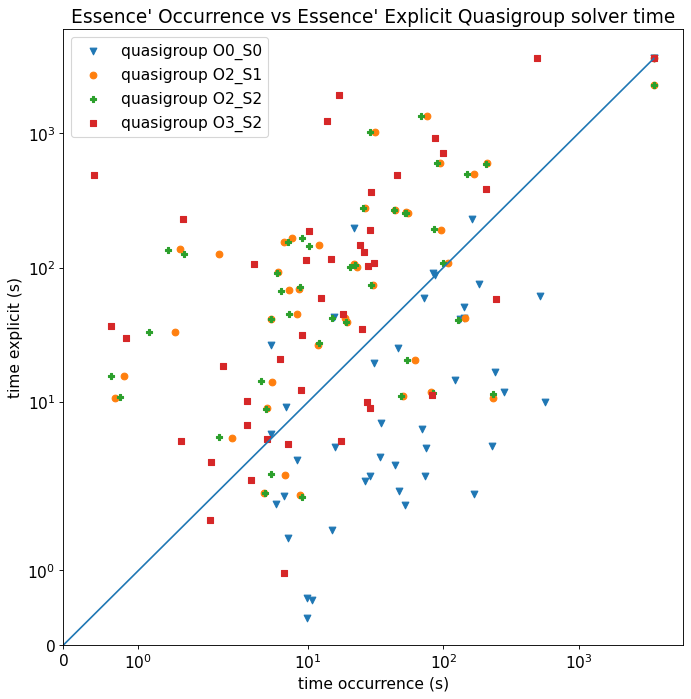

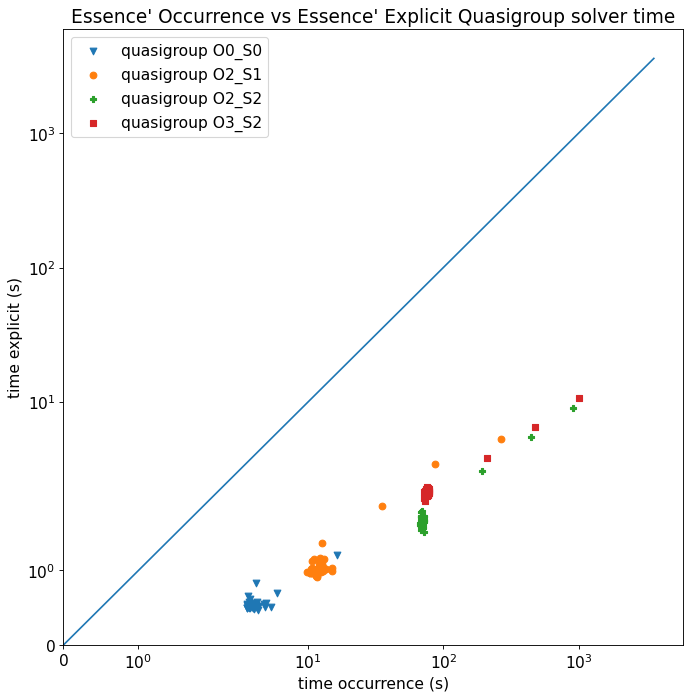

In [8]:
setupPlotSolverSolver("Essence' Occurrence vs Essence' Explicit Quasigroup")
for solver in ["chuffed"]:
    for flag in ["free"]:
        for j in optimisations:
            createOccurencePlot(j, allEprimeTimings[quasigroupOcc + "_" + flag + "_" + solver][j], allEprimeTimings[quasigroup  + "_" + flag + "_" + solver][j])
plt.legend(loc="best")

setupPlotSolverSolver("Essence' Occurrence vs Essence' Explicit Quasigroup", solverTimeIndex)
for solver in ["chuffed"]:
    for flag in ["free"]:
        for j in optimisations:
            createOccurencePlot(j, allEprimeTimings[quasigroupOcc + "_" + flag + "_" + solver][j], allEprimeTimings[quasigroup  + "_" + flag + "_" + solver][j], indexOfInterest=solverTimeIndex)
plt.legend(loc="best")

setupPlotSolverSolver("Essence' Occurrence vs Essence' Explicit Quasigroup", solverTimeIndex)
for solver in ["chuffed"]:
    for flag in ["free"]:
        for j in optimisations:
            createOccurencePlot(j, allEprimeTimings[quasigroupOcc + "_" + flag + "_" + solver][j], allEprimeTimings[quasigroup  + "_" + flag + "_" + solver][j], indexOfInterest=initIndex)
plt.legend(loc="best")

# setupPlotSolverSolver("Essence' Occurrence vs Essence' Explicit Quasigroup", initIndex)
# for j in optimisations:
#     createOccurencePlot(j, allEprimeTimings[quasigroupOcc][j], allEprimeTimings[quasigroup][j], indexOfInterest=initIndex, errorbars=True)
# plt.legend(loc="best")

# setupPlotSolverSolver("Minizinc Occurrence vs Minizinc Explicit Quasigroup")
# createOccurencePlot("", allMinizincTimings[quasigroupOcc], allMinizincTimings[quasigroup], errorbars=True)
# plt.legend(loc="best")


# setupPlotSolverSolver("Minizinc Occurrence vs Minizinc Explicit Quasigroup", solverTimeIndex)
# createOccurencePlot("", allMinizincTimings[quasigroupOcc], allMinizincTimings[quasigroup], indexOfInterest=solverTimeIndex, errorbars=True)
# plt.legend(loc="best")


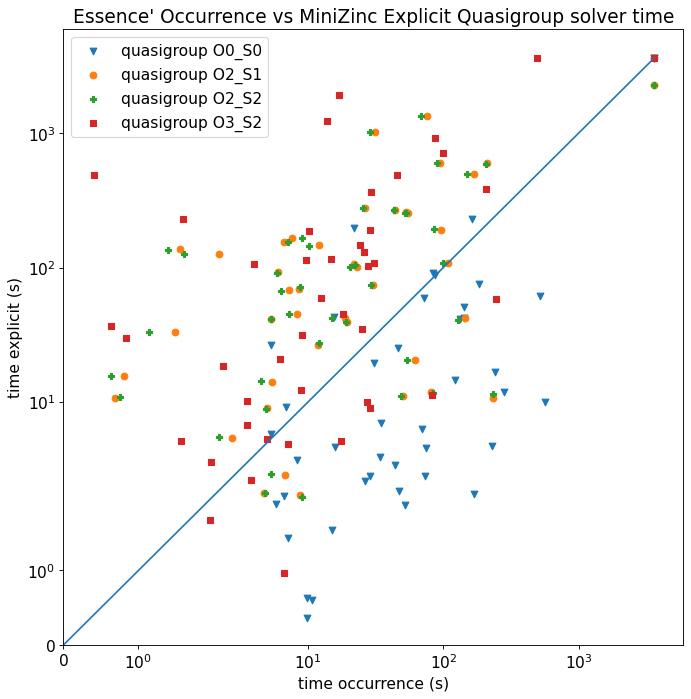

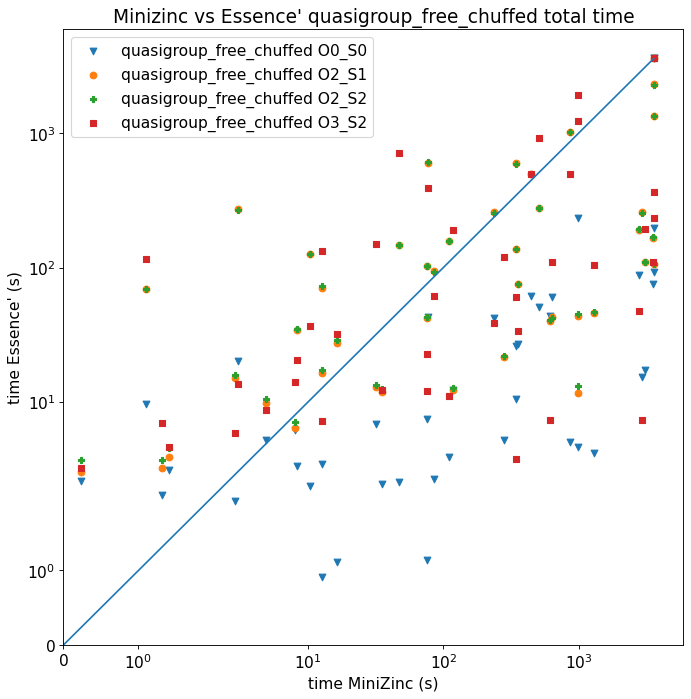

In [9]:
setupPlotSolverSolver("Essence' Occurrence vs MiniZinc Explicit Quasigroup", solverTimeIndex)
for j in optimisations:
# for j in ["O2_S1"]:
    # createOccurencePlot(j, allEprimeTimings[quasigroupOcc + "_free_chuffed"][j], allMinizincTimings[quasigroup+ "_free_chuffed"], indexOfInterest=solverTimeIndex)
    createOccurencePlot(j, allEprimeTimings[quasigroupOcc + "_free_chuffed"][j], allEprimeTimings[quasigroup+ "_free_chuffed"][j], indexOfInterest=solverTimeIndex)
plt.legend(loc="best")

setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [quasigroup + "_free_chuffed"])
plt.legend(loc="best")

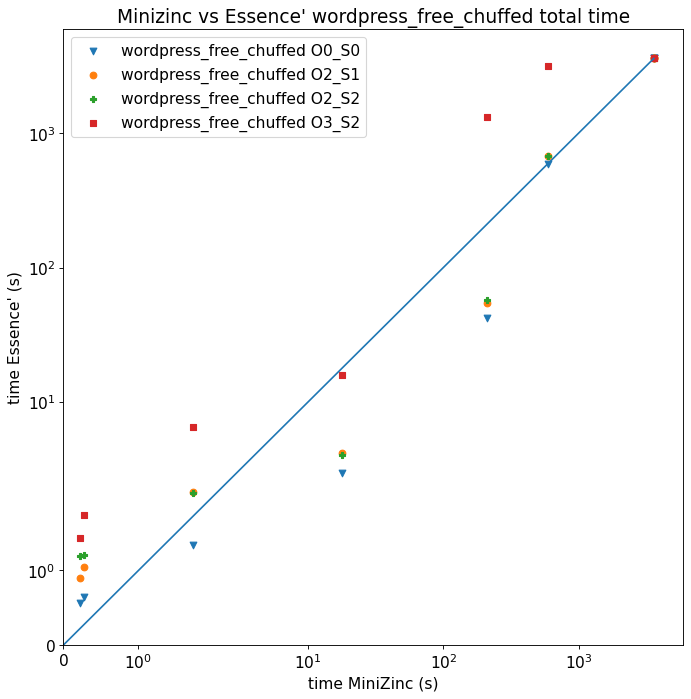

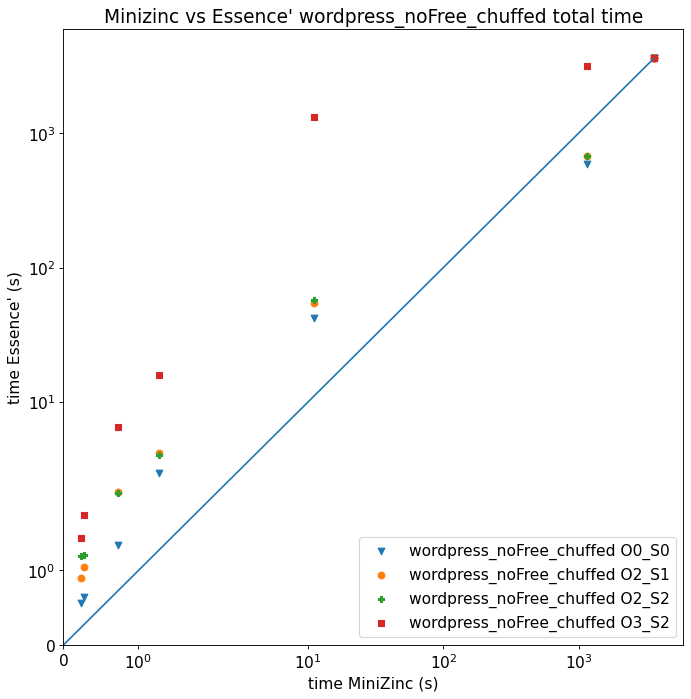

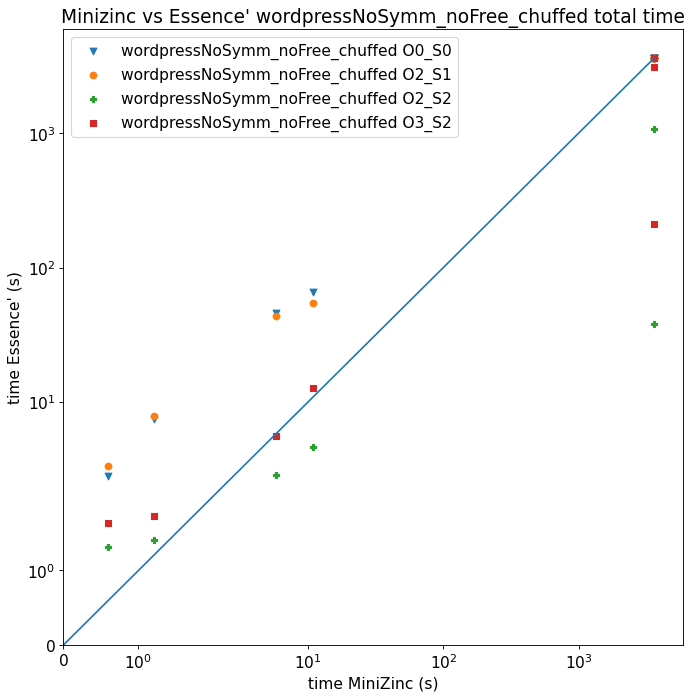

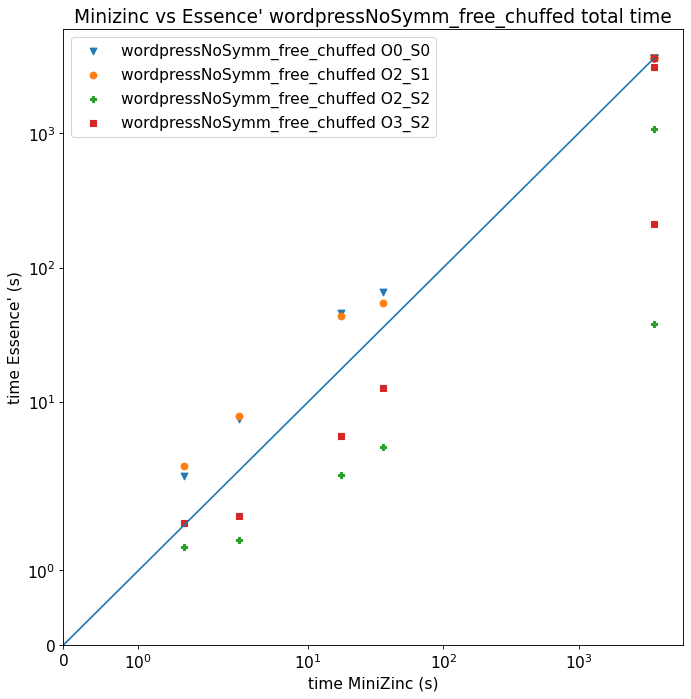

In [10]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [wordpress + "_free_chuffed"])
plt.legend(loc="best")

setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [wordpress + "_noFree_chuffed"])
plt.legend(loc="best")

setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [wordpressNoSymm + "_noFree_chuffed"])
plt.legend(loc="best")

setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [wordpressNoSymm + "_free_chuffed"])
plt.legend(loc="best")

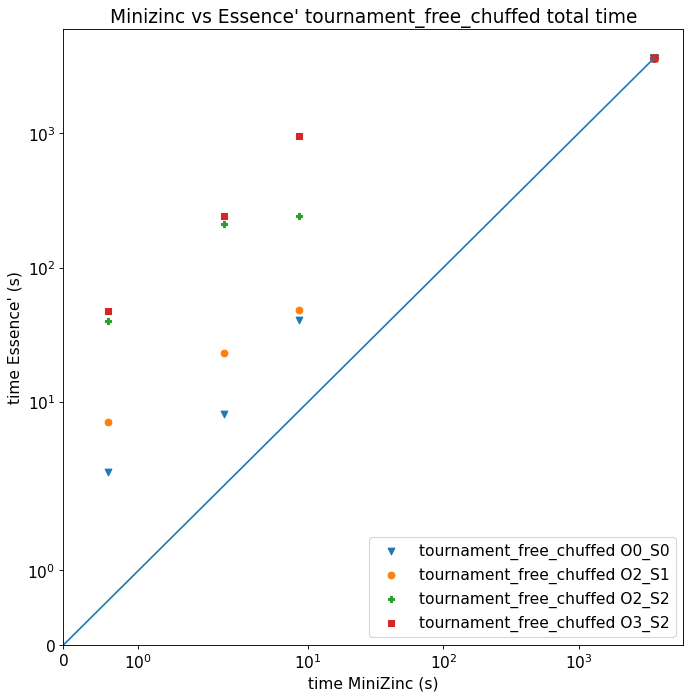

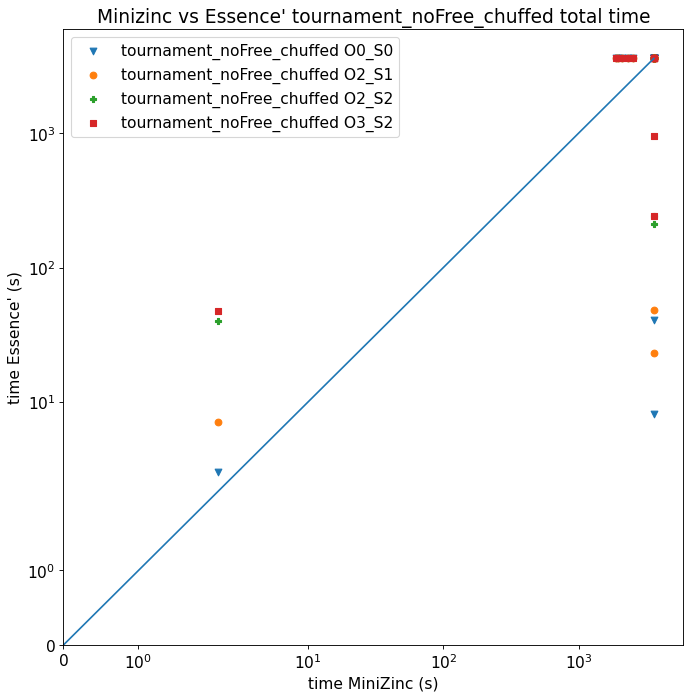

In [11]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [tournament + "_free_chuffed"])
plt.legend(loc="best")

setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [tournament + "_noFree_chuffed"])
plt.legend(loc="best")

In [12]:
# for i in chuffedProblems:
#     setupPlotSolverSolver()
#     for j in optimisations:
#         createPlot(j, [i], errorbars=False)
#     plt.legend(loc="best")

# for i in chuffedProblems:
#     setupPlotSolverSolver()
#     for j in optimisations:
#         createPlot(j, [i], errorbars=False, indexOfInterest=solverTimeIndex)
#     plt.legend(loc="best")

['quasigroup_free_chuffed', 'wordpress_free_chuffed', 'wordpressNoSymm_free_chuffed', 'tournament_free_chuffed', 'mspsp_free_chuffed', 'cvrptw_free_chuffed', 'roster_free_chuffed']
['quasigroup_noFree_chuffed', 'wordpress_noFree_chuffed', 'wordpressNoSymm_noFree_chuffed', 'tournament_noFree_chuffed', 'mspsp_noFree_chuffed', 'cvrptw_noFree_chuffed', 'roster_noFree_chuffed']






/tmp/ipykernel_1687178/1858162282.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure(figsize=(10, 10), dpi=80)


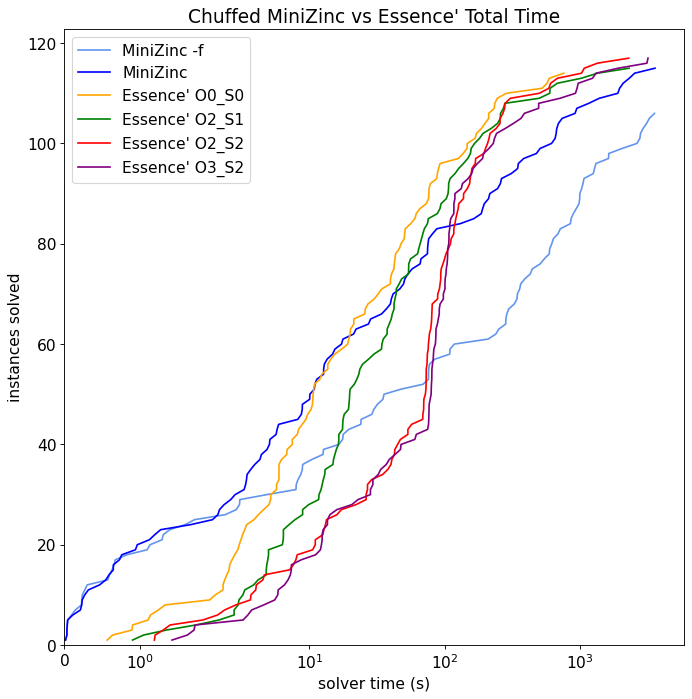

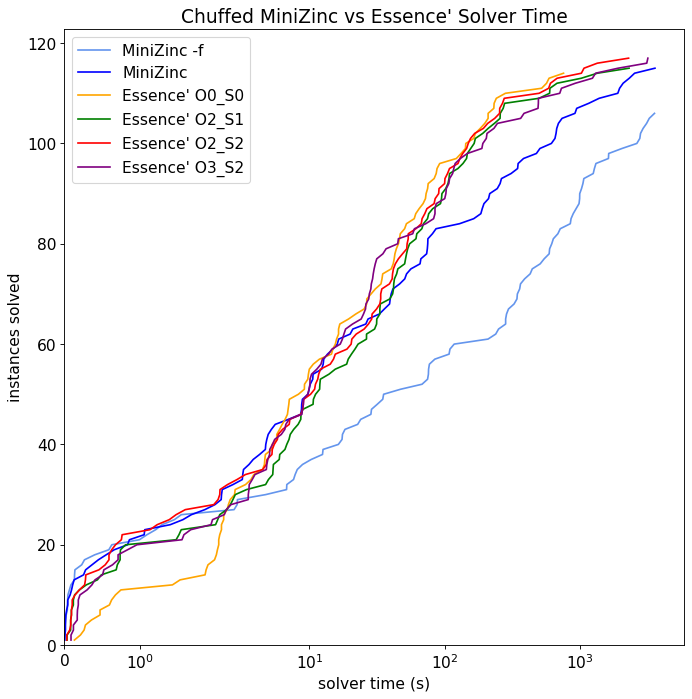

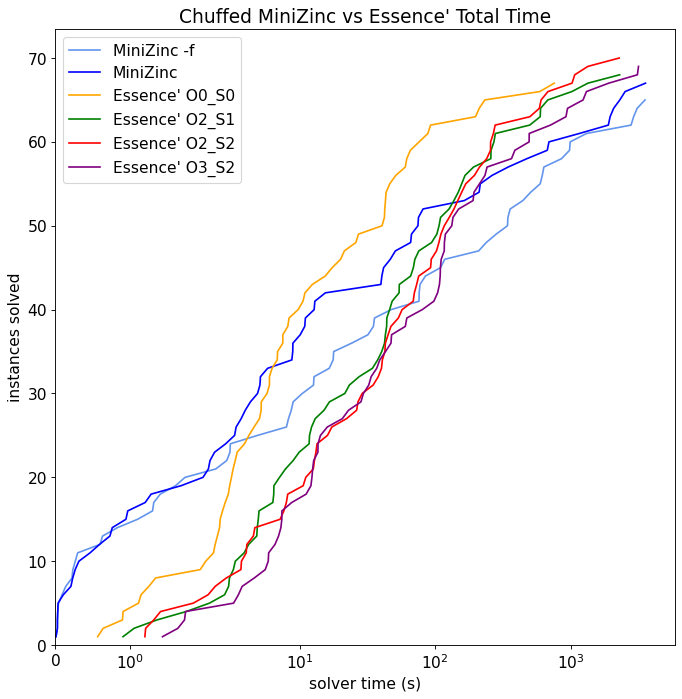

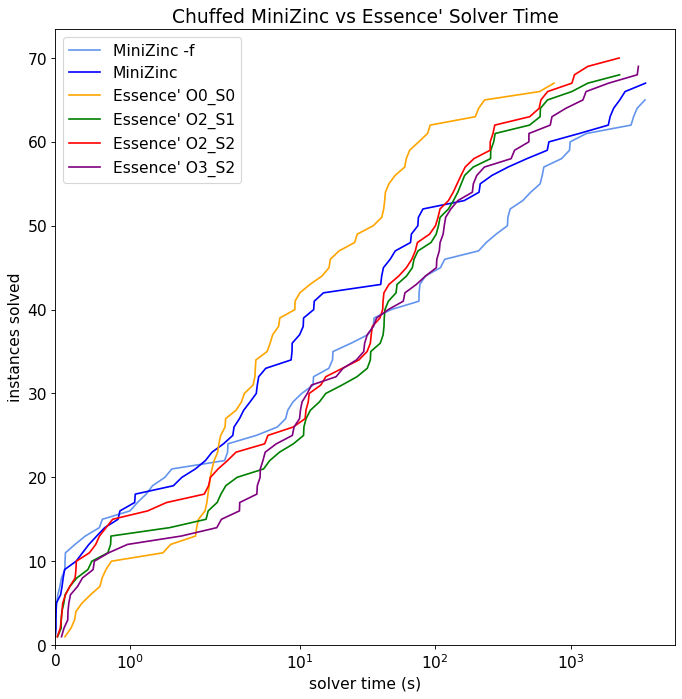

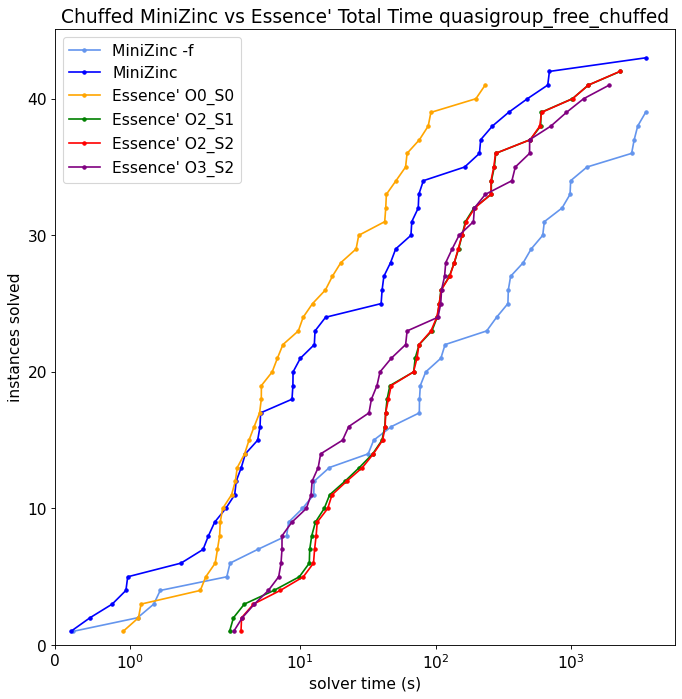

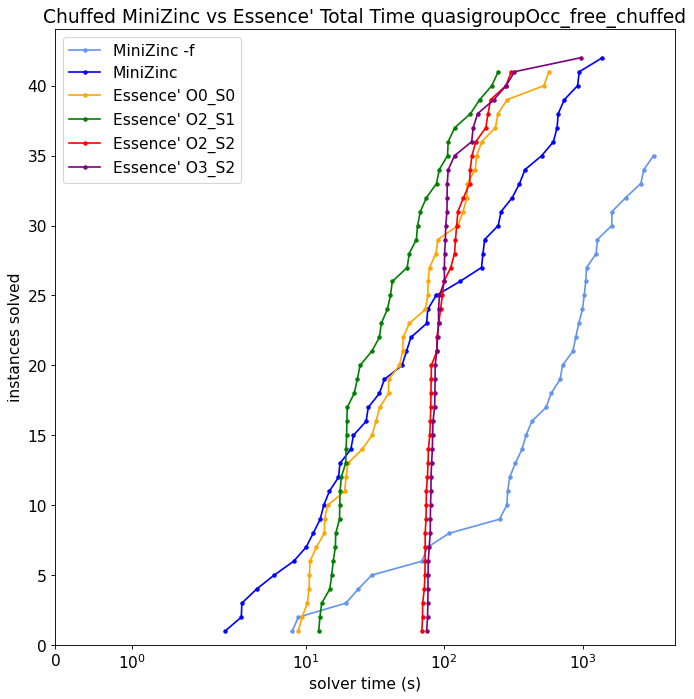

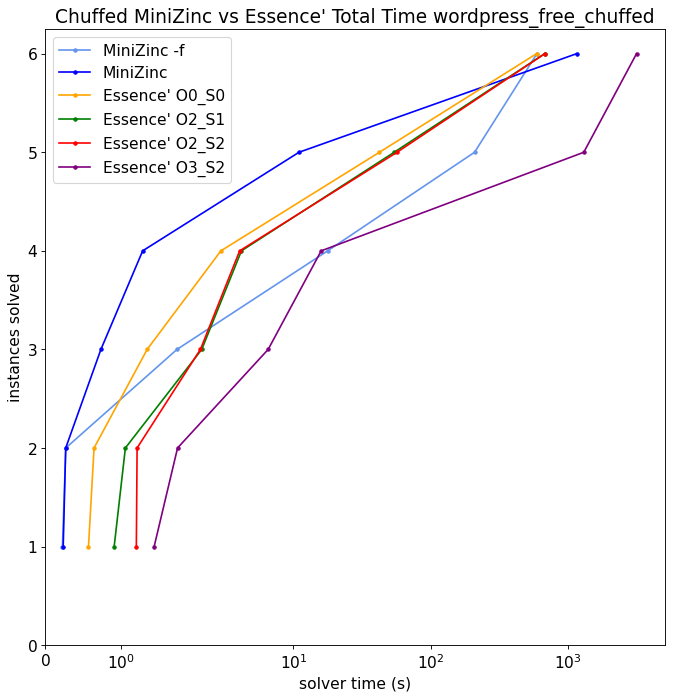

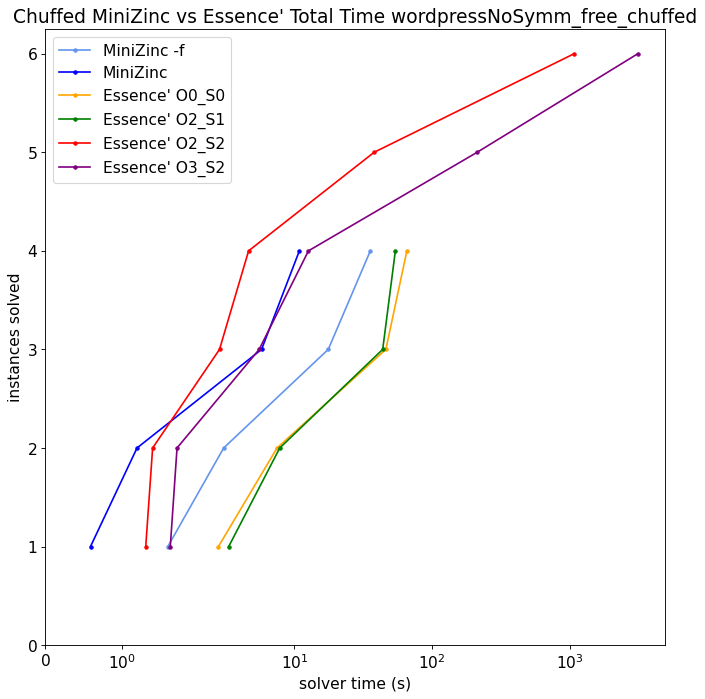

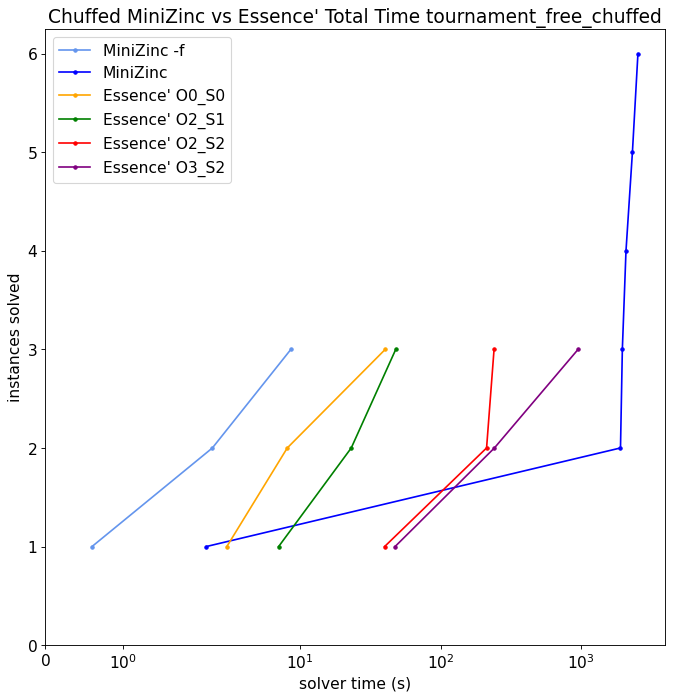

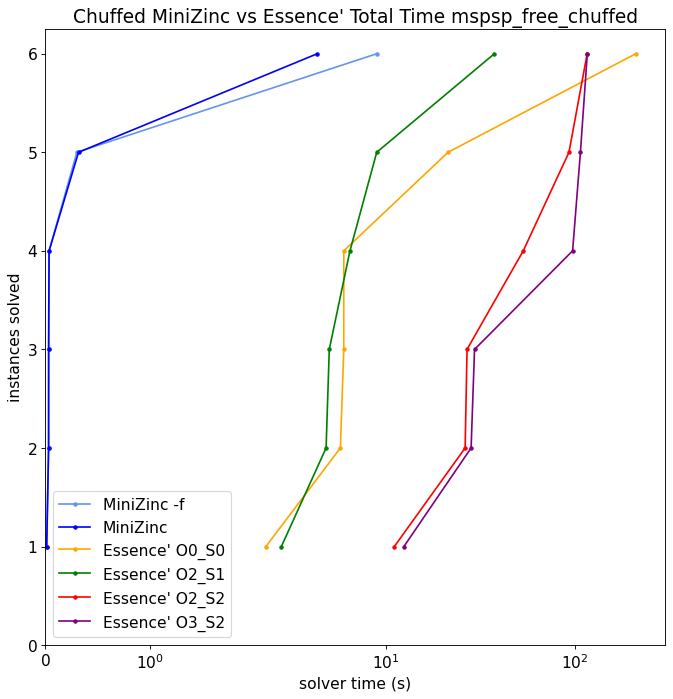

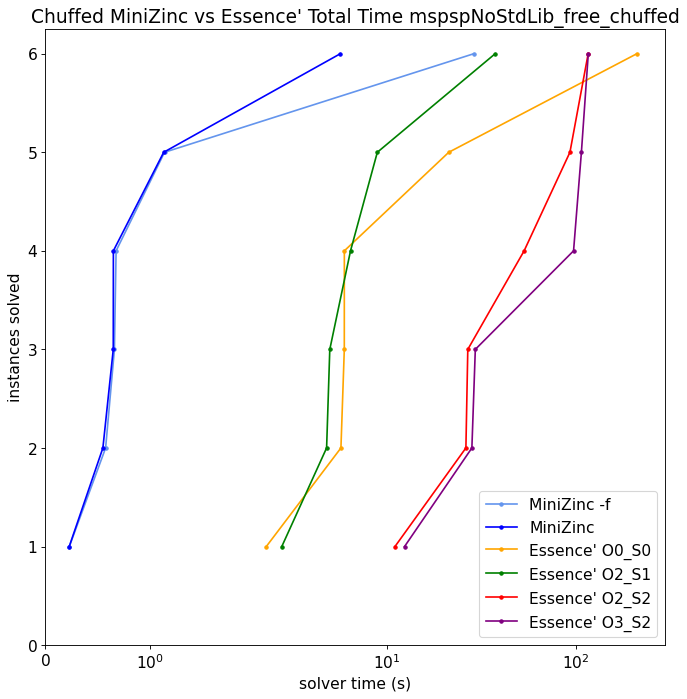

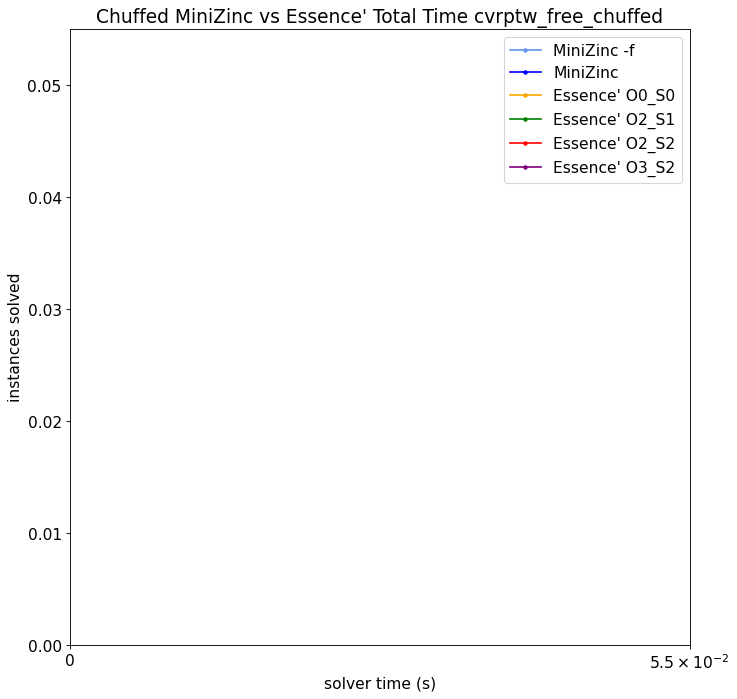

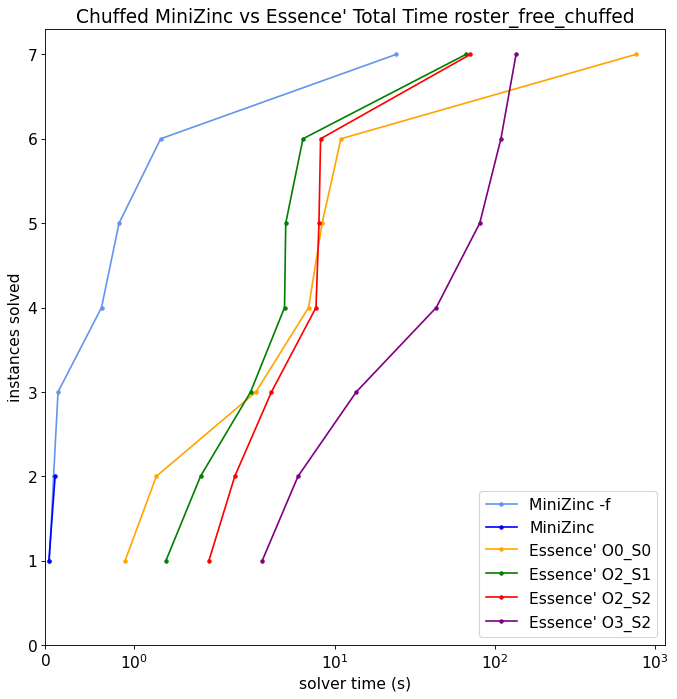

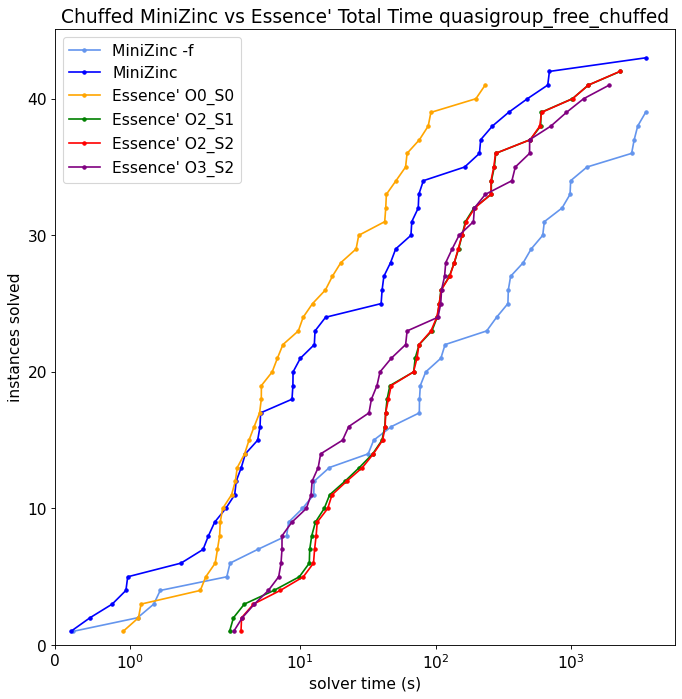

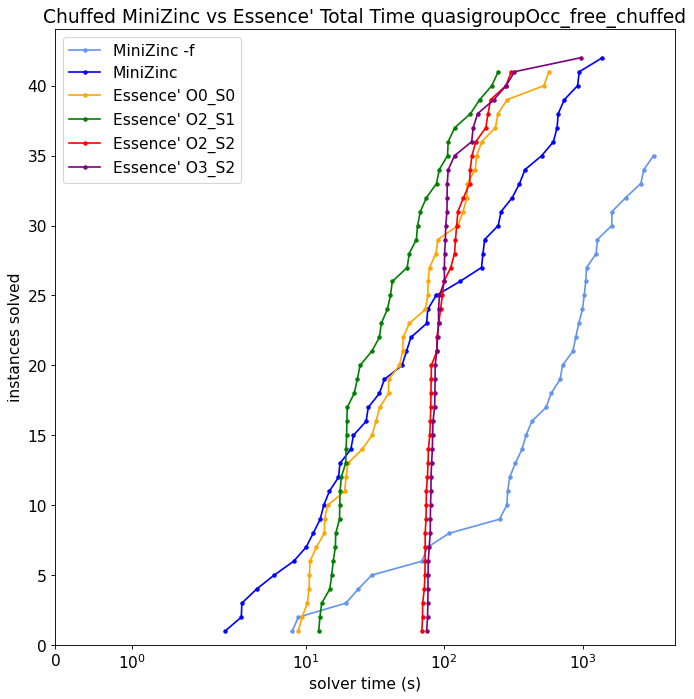

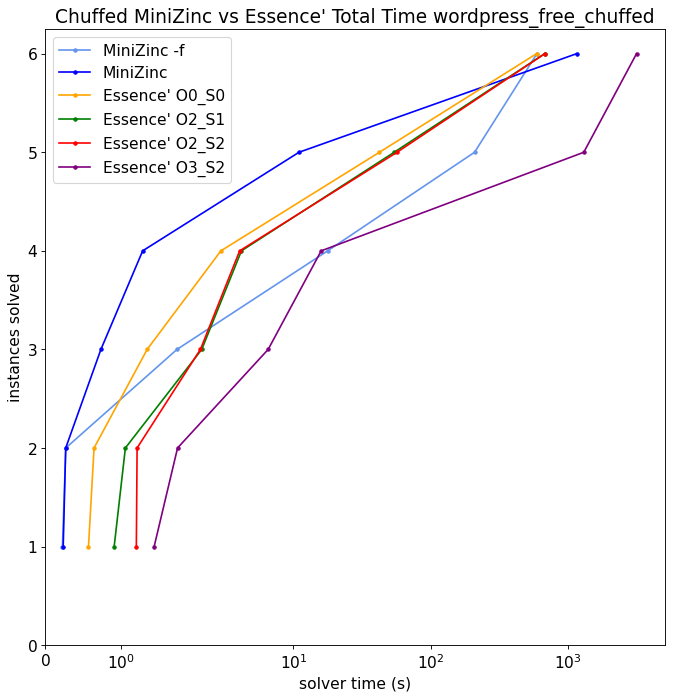

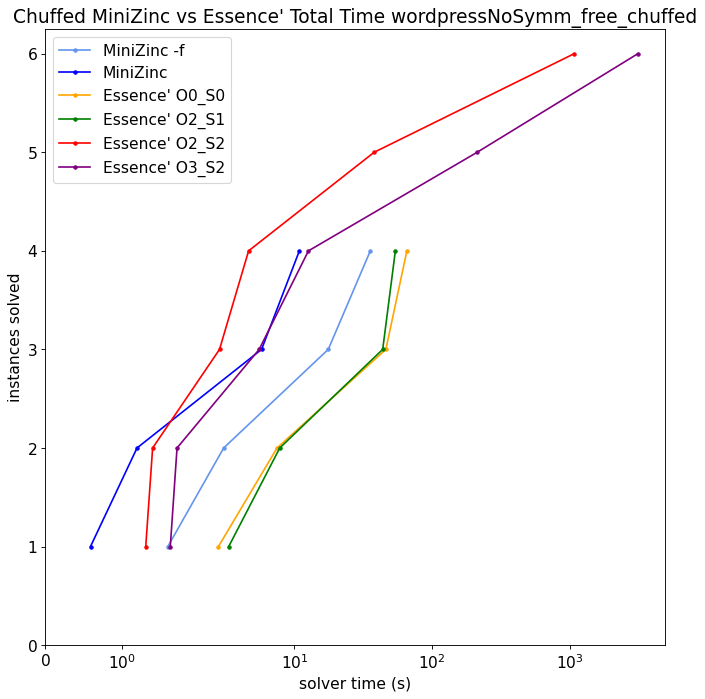

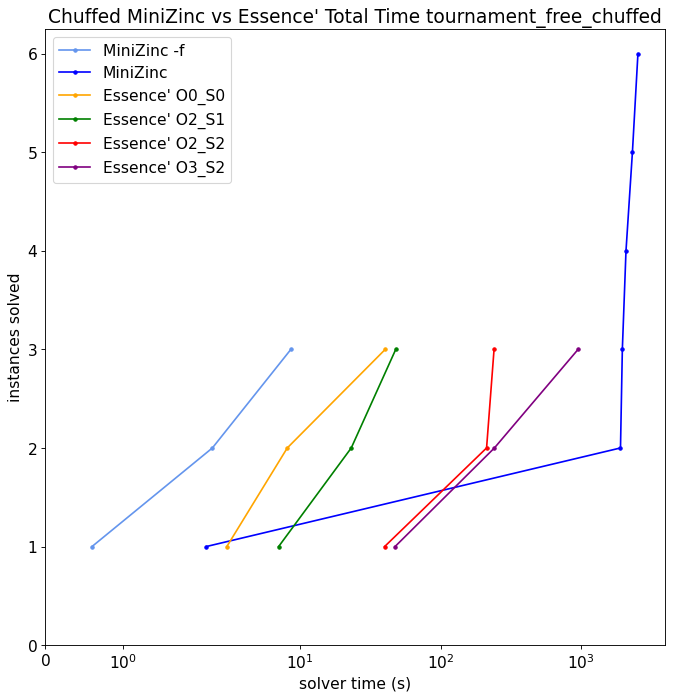

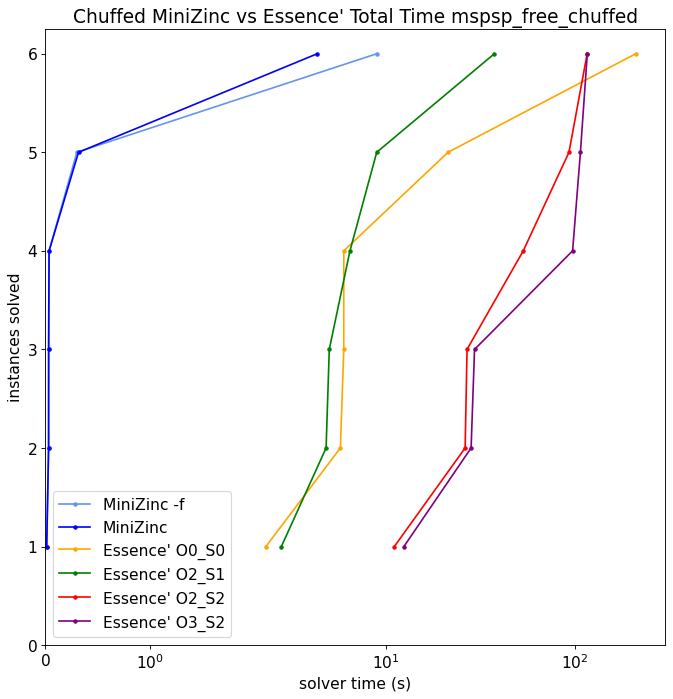

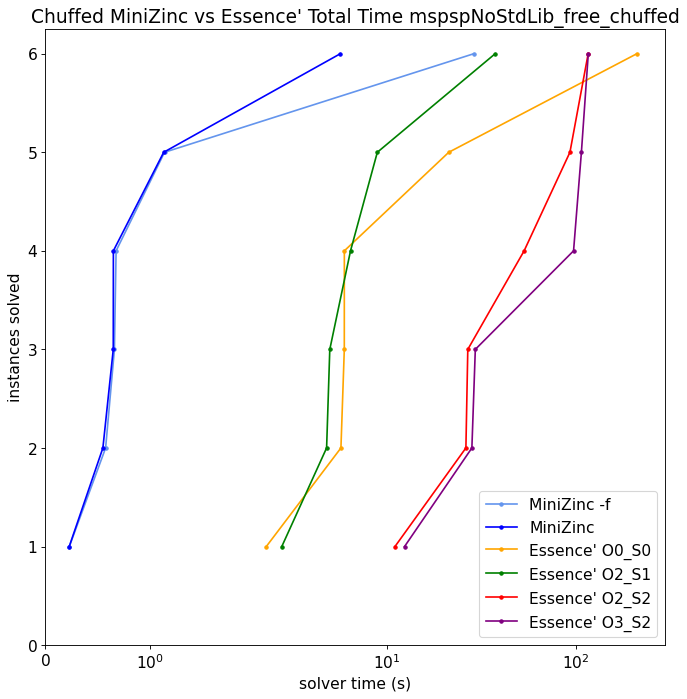

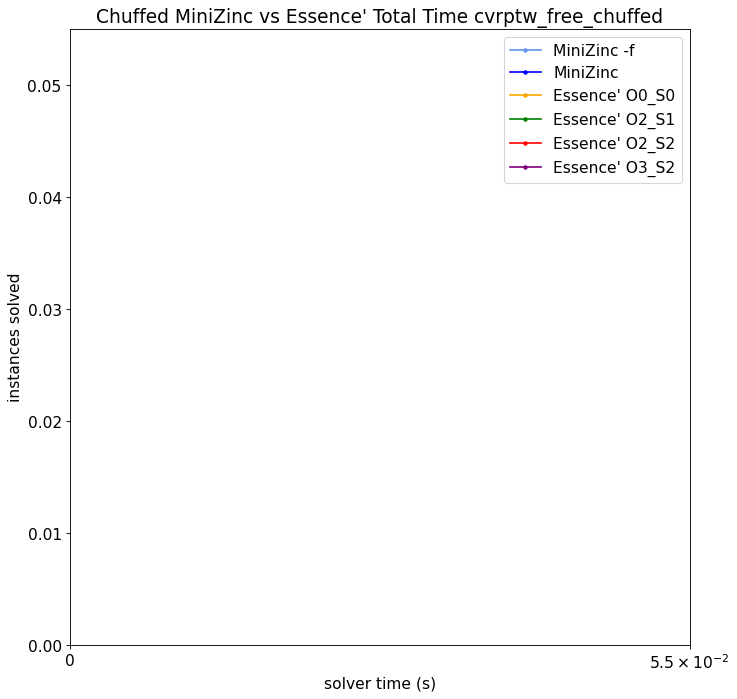

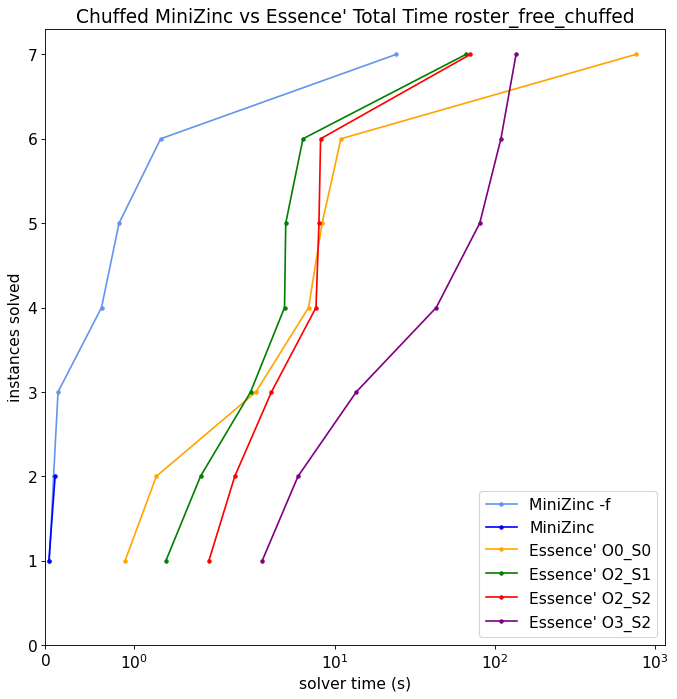

In [13]:
import numpy as np

def setupCumulativePlot(title):
    figure(figsize=(10, 10), dpi=80)
    plt.xlabel("solver time (s)")
    plt.ylabel("instances solved")
    plt.xscale("symlog")
    plt.title(title)
    plt.rcParams['font.size'] = 14

# plt.rcParams['font.size'] = 14

# def plotInvValues(xValues, yValues, label):
#     plt.plot(xValues, yValues, label=label)
    # plt.xlim(max(xValues), min(xValues))
    # plt.ylim(max(yValues), min(yValues))

def getTimingCompleted(problemIndex, opt=None, indexToGet=timingIndex):
    lstToGet = allMinizincTimings[problemIndex]
    if opt != None:
        lstToGet = allEprimeTimings[problemIndex][opt]
    return [lstToGet[indexToGet][i] for i in range(len(lstToGet[indexToGet])) if not lstToGet[timeoutIndex][i]]
    # return [lstToGet[indexToGet][i] for i in range(len(lstToGet[indexToGet]))]


def createCumulativePlot(problemList=problems, opt=None, label="Essence' ", color=None, markers=None, indx=timingIndex):
    xValues = []
    allTimings = []
    for i in problemList:
        allTimings.extend(getTimingCompleted(i, opt, indx))
        # if opt == "O0_S0":
        #     print(i)
        #     print(getTimingCompleted(i, opt, std))
    allTimings.sort()
    # print(len(allTimings))
    yValues = [i for i in range(1, len(allTimings)+1)]
    xValues = allTimings
    plt.plot(xValues, yValues, label=label + (opt if opt else ""), color=color, marker=markers)
    plt.locator_params(axis="y", integer=True)
    

# setupCumulativePlot("Cactus Minizinc vs Essence'")
# createCumulativePlot(label="MiniZinc")
# print()
# for opt in optimisations:
# # for opt in ["O0_S0"]:
#     createCumulativePlot(opt=opt)
# plt.xlim(left=0)
# plt.ylim(bottom=0)
# plt.legend(loc="best")

# minizinc solving 16 fewer problems without the free flag

coloring = {}
coloring["O0_S0"] = "orange"
coloring["O2_S1"] = "green"
coloring["O2_S2"] = "red"
coloring["O3_S2"] = "purple"
coloring["mzn"] = "blue"
coloring["mzn_free"] = "cornflowerblue"

originalFreeProblems = freeProblems.copy()
originalNoFreeProblems = noFreeProblems.copy()

for i in [mspspNoStdLib, quasigroupOcc]:
# for i in [tournament, roster]:
    originalFreeProblems.remove(i + "_free_chuffed")
    originalNoFreeProblems.remove(i + "_noFree_chuffed")

print(originalFreeProblems)
print(originalNoFreeProblems)

setupCumulativePlot("Chuffed MiniZinc vs Essence' Total Time")
createCumulativePlot(problemList=freeProblems, label="MiniZinc -f", color=coloring["mzn_free"])
createCumulativePlot(problemList=noFreeProblems, label="MiniZinc", color=coloring["mzn"])
print()
for opt in optimisations:
# for opt in ["O0_S0"]:
    createCumulativePlot(problemList=freeProblems, opt=opt, color=coloring[opt])
plt.legend(loc="best")
plt.xlim(left=0)
plt.ylim(bottom=0)

setupCumulativePlot("Chuffed MiniZinc vs Essence' Solver Time")
createCumulativePlot(problemList=freeProblems, label="MiniZinc -f", color=coloring["mzn_free"], indx=solverTimeIndex)
createCumulativePlot(problemList=noFreeProblems, label="MiniZinc", color=coloring["mzn"], indx=solverTimeIndex)
print()
for opt in optimisations:
# for opt in ["O0_S0"]:
    createCumulativePlot(problemList=freeProblems, opt=opt, color=coloring[opt], indx=solverTimeIndex)
plt.legend(loc="best")
plt.xlim(left=0)
plt.ylim(bottom=0)

setupCumulativePlot("Chuffed MiniZinc vs Essence' Total Time")
createCumulativePlot(problemList=originalFreeProblems, label="MiniZinc -f", color=coloring["mzn_free"])
createCumulativePlot(problemList=originalNoFreeProblems, label="MiniZinc", color=coloring["mzn"])
print()
for opt in optimisations:
# for opt in ["O0_S0"]:
    createCumulativePlot(problemList=originalFreeProblems, opt=opt, color=coloring[opt])
plt.legend(loc="best")
plt.xlim(left=0)
plt.ylim(bottom=0)

setupCumulativePlot("Chuffed MiniZinc vs Essence' Solver Time")
createCumulativePlot(problemList=originalFreeProblems, label="MiniZinc -f", color=coloring["mzn_free"], indx=solverTimeIndex)
createCumulativePlot(problemList=originalNoFreeProblems, label="MiniZinc", color=coloring["mzn"], indx=solverTimeIndex)
print()
for opt in optimisations:
# for opt in ["O0_S0"]:
    createCumulativePlot(problemList=originalFreeProblems, opt=opt, color=coloring[opt], indx=solverTimeIndex)
plt.legend(loc="best")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend(loc="best")
plt.xlim(left=0)
plt.ylim(bottom=0)

# for i in range(len(allEprimeTimings["cvrptw_free_chuffed"]["O2_S1"][0])):
#     print(allEprimeTimings["cvrptw_free_chuffed"]["O2_S1"][0][i], allEprimeTimings["cvrptw_free_chuffed"]["O2_S1"][1][i])
# print(allEprimeTimings["tournament_free_chuffed"]["O2_S1"])

for i in freeProblems:
    setupCumulativePlot("Chuffed MiniZinc vs Essence' Total Time " + i)
    createCumulativePlot(problemList=[i], label="MiniZinc -f", color=coloring["mzn_free"], markers=".")
    createCumulativePlot(problemList=[i.split("_")[0] + "_noFree_chuffed"], label="MiniZinc", color=coloring["mzn"], markers=".")
    for opt in optimisations:
    # for opt in ["O0_S0"]:
        createCumulativePlot(problemList=[i], opt=opt, color=coloring[opt], markers=".")
    plt.legend(loc="best")
    plt.xlim(left=0)
    plt.ylim(bottom=0)

for i in freeProblems:
    setupCumulativePlot("Chuffed MiniZinc vs Essence' Total Time " + i)
    createCumulativePlot(problemList=[i], label="MiniZinc -f", color=coloring["mzn_free"], markers=".")
    createCumulativePlot(problemList=[i.split("_")[0] + "_noFree_chuffed"], label="MiniZinc", color=coloring["mzn"], markers=".")
    for opt in optimisations:
    # for opt in ["O0_S0"]:
        createCumulativePlot(problemList=[i], opt=opt, color=coloring[opt], markers=".")
    plt.legend(loc="best")
    plt.xlim(left=0)
    plt.ylim(bottom=0)

# for opt in optimisations:
    # setupCumulativePlot(opt)
    # createCumulativePlot(opt)


In [14]:
# setupCumulativePlot("cactus no free flag minizinc vs essence")
# print()

# for opt in optimisations:
# # for opt in ["O0_S0"]:
#     createCumulativePlot(problemList=noFreeProblems, opt=opt)
# plt.legend(loc="best")

# setupCumulativePlot("cactus chuffed minizinc vs essence")
# print()
# createCumulativePlot(problemList=chuffedProblems)
# for opt in optimisations:
# # for opt in ["O0_S0"]:
#     createCumulativePlot(problemList=chuffedProblems, opt=opt)
# plt.legend(loc="best")

# setupCumulativePlot("cactus gecode minizinc vs essence")
# print()
# createCumulativePlot(problemList=gecodeProblems)
# for opt in optimisations:
# # for opt in ["O0_S0"]:
#     createCumulativePlot(problemList=gecodeProblems, opt=opt)
# plt.legend(loc="best")

# setupCumulativePlot("selective cactus -f flag minizinc vs essence")
# test = [tournamentFree, rosterFree, mspsp, cvrptw, wordpress, wordpressNoSymm, quasigroup]
# createCumulativePlot(problemList=test)
# for opt in optimisations:
# # for opt in ["O0_S0"]:
#     createCumulativePlot(problemList=test, opt=opt)
# plt.legend(loc="best")

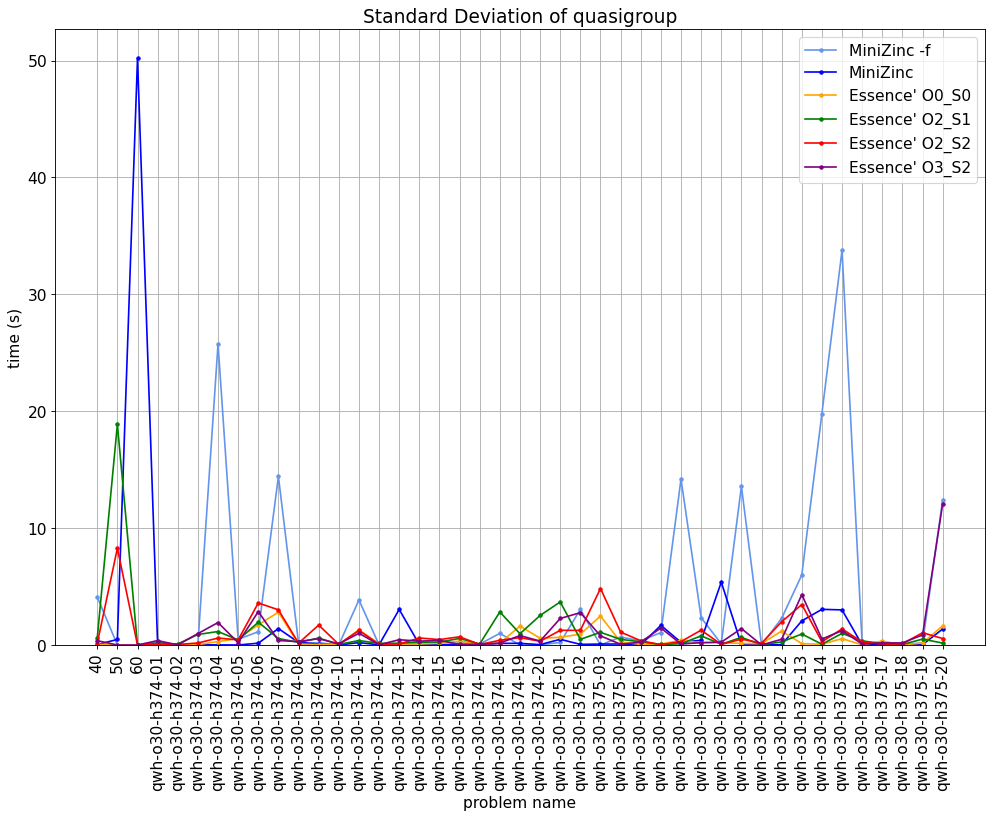

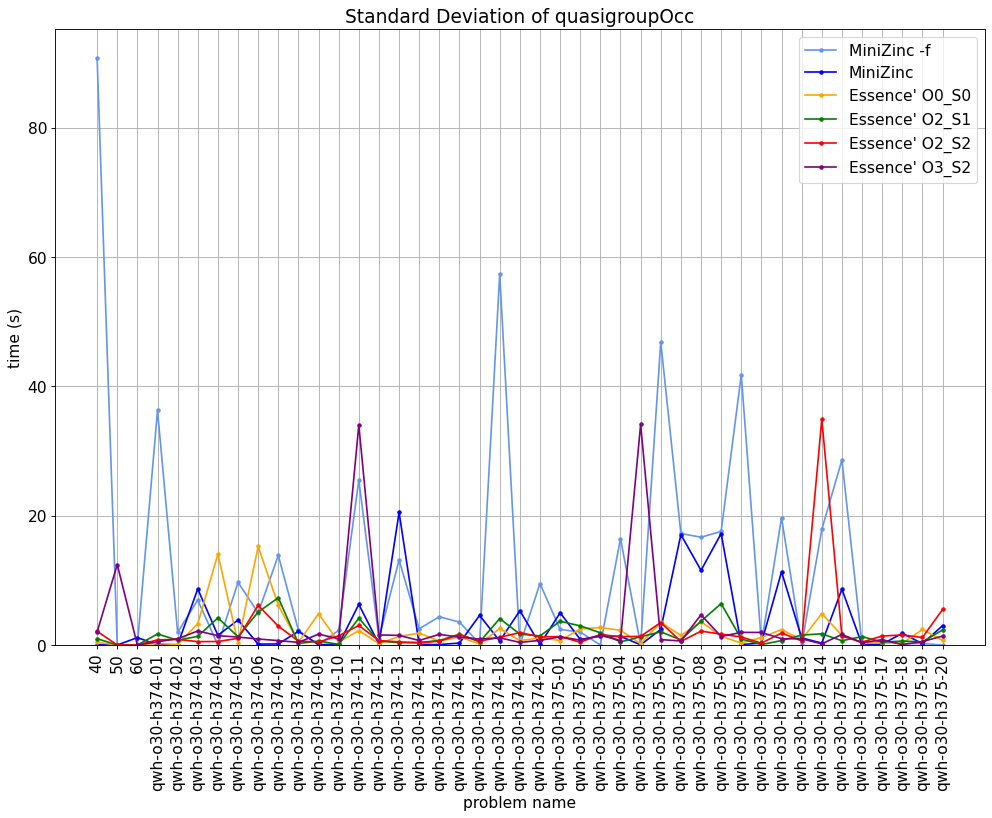

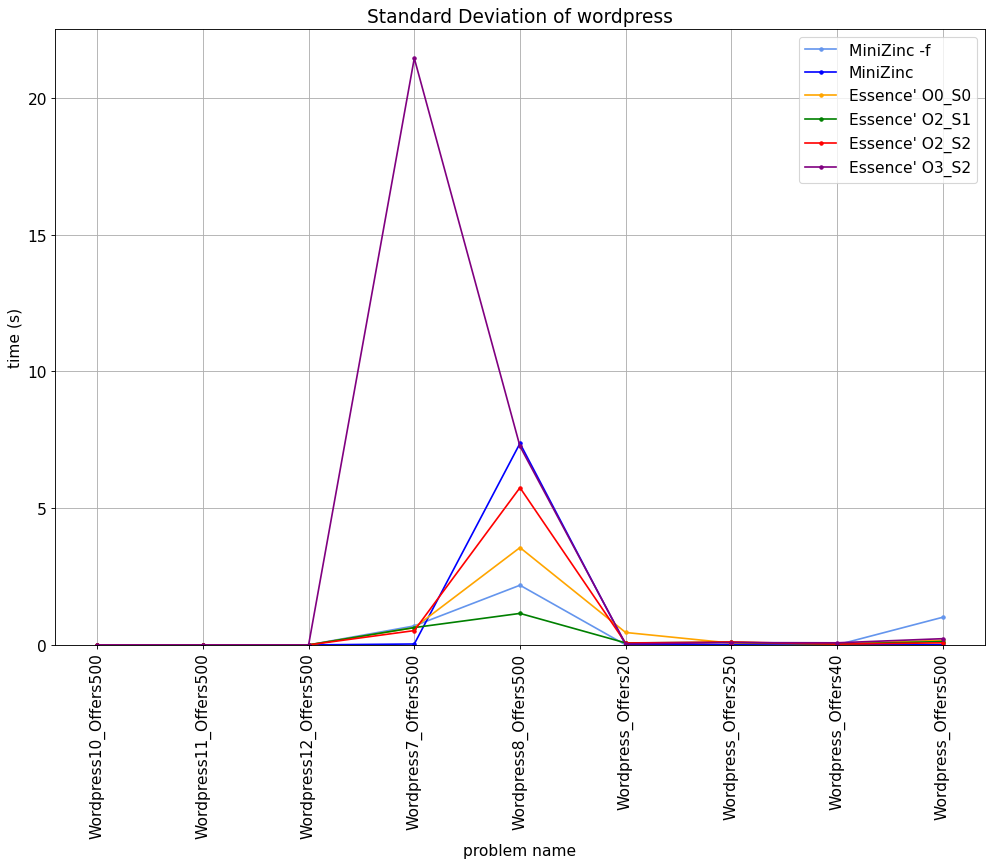

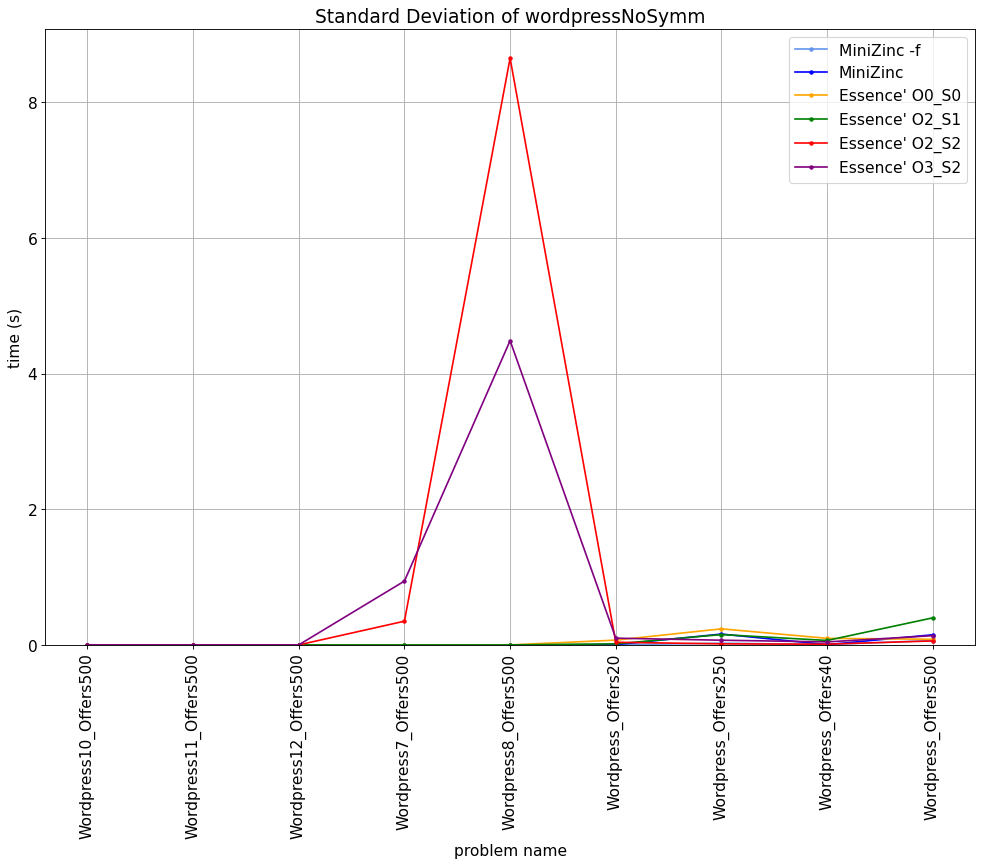

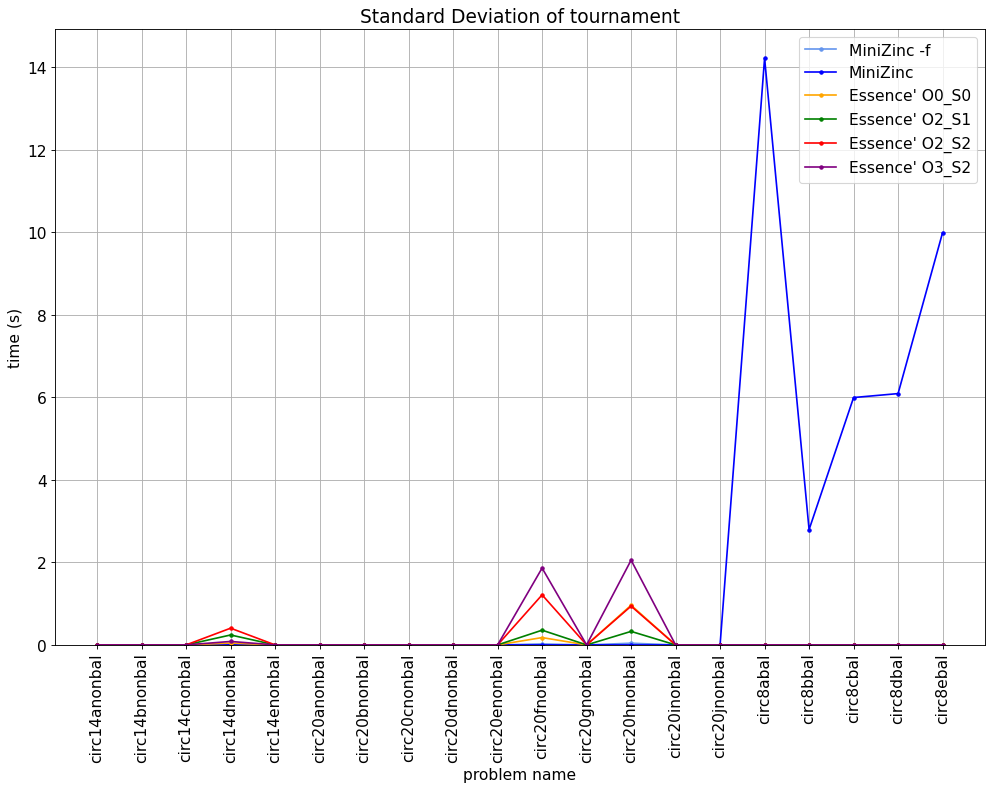

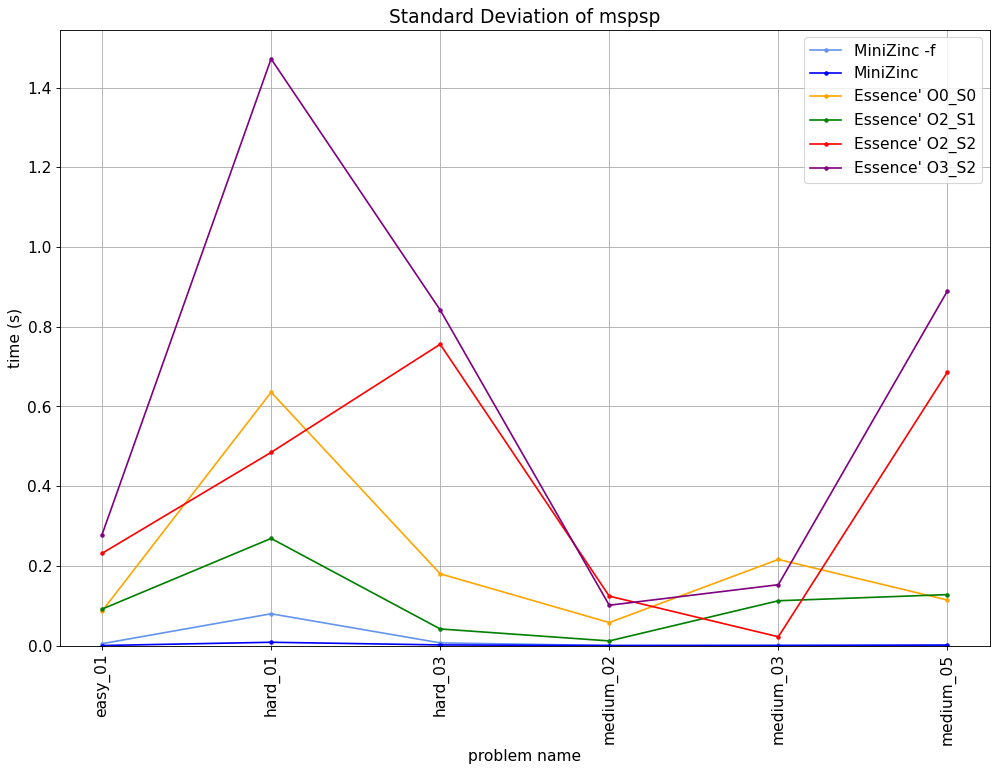

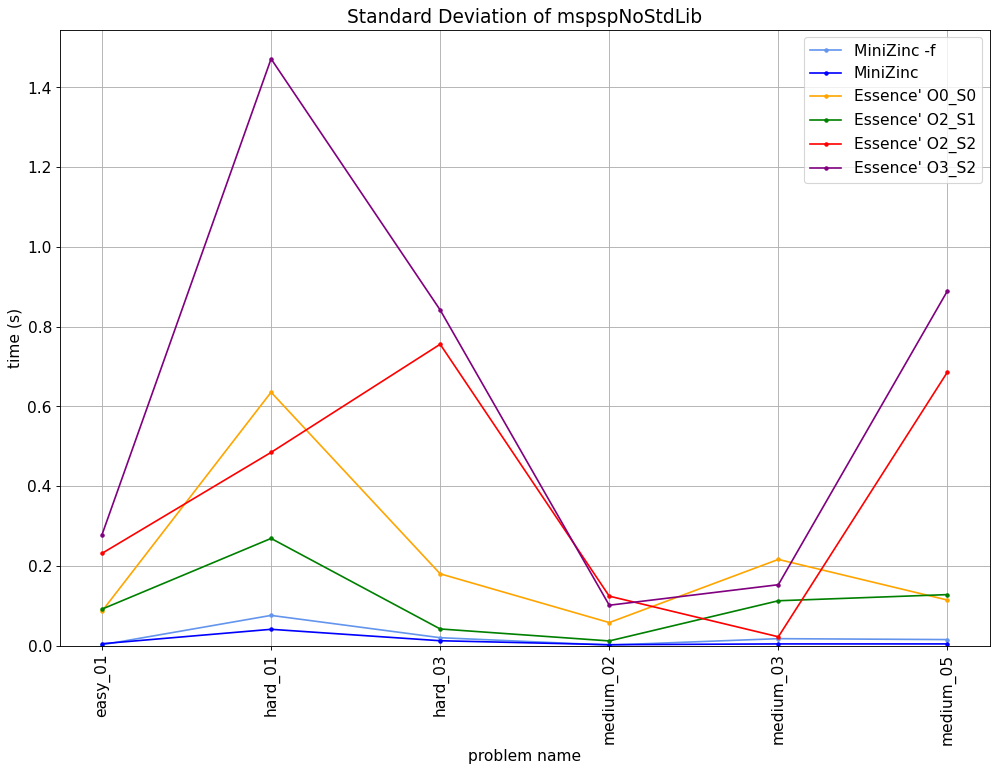

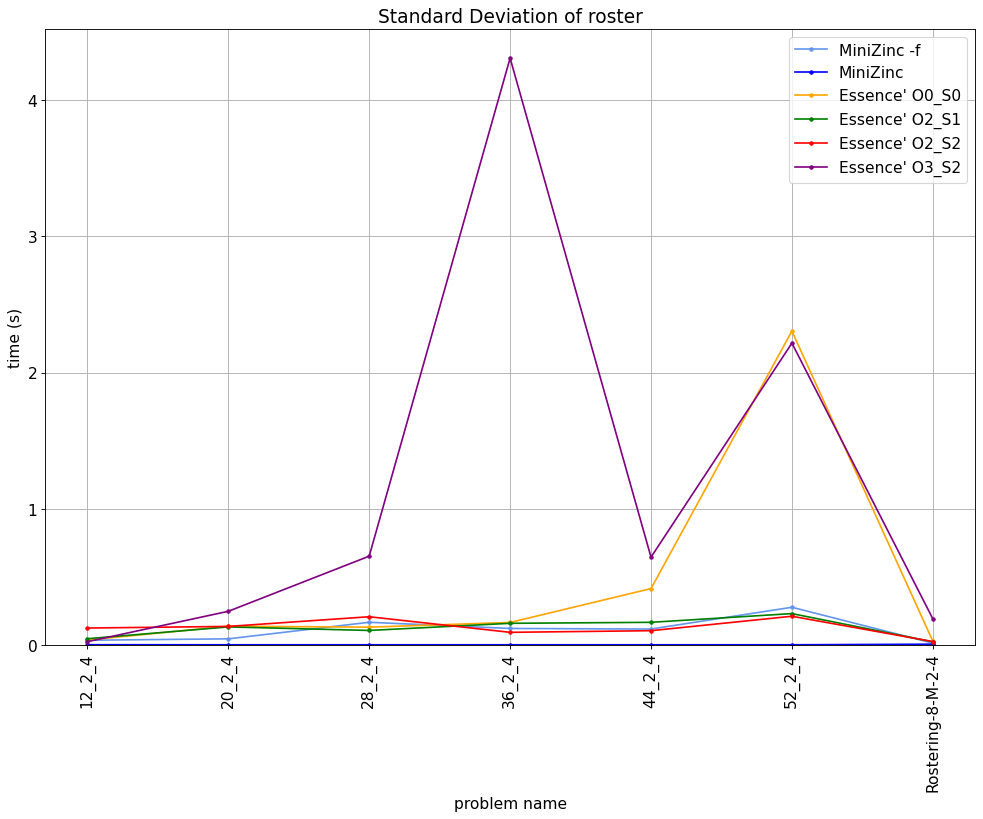

In [15]:
def setupStdPlot(title):
    figure(figsize=(15, 10), dpi=80)
    plt.rcParams['font.size'] = 14
    plt.xlabel("problem name")
    plt.ylabel("time (s)")
    plt.xticks(rotation = 90)
    # plt.yscale("symlog")
    plt.title(title)
    plt.grid()

def plotStd(toGraph, label=None, stdDevIndex=timingStdevIndex, color=None):
    xVals, yVals = toGraph[problemIndex], toGraph[stdDevIndex]
    xVals = [i.split(".")[0] for i in xVals]
    plt.plot(xVals, yVals, label=label, color=color, marker='.', linestyle="-")

for problem in freeProblems:
    if 'cvr' in problem:
        continue
    setupStdPlot("Standard Deviation of " + problem.split("_")[0])
    plotStd(allMinizincTimings[problem], label="MiniZinc -f", color=coloring["mzn_free"])
    plotStd(allMinizincTimings[problem.split("_")[0] + "_noFree_chuffed"], label="MiniZinc", color=coloring["mzn"])
    for opt in optimisations:
        plotStd(allEprimeTimings[problem][opt], label="Essence' " + opt, color=coloring[opt])
    plt.ylim(bottom=0)
    plt.legend(loc="best")
    

In [16]:
for problem in problems:
    print(problem)
    print("num instances", len(allMinizincTimings[problem][problemIndex]))
    print("mzn", len([i for i in allMinizincTimings[problem][timeoutIndex] if not i]))
    # print([allMinizincTimings[problem][problemIndex][i] for i in range(len(allMinizincTimings[problem][problemIndex])) if not allMinizincTimings[problem][timeoutIndex][i]])
    for opt in optimisations:
        print(opt, len([i for i in allEprimeTimings[problem][opt][timeoutIndex] if not i]))
    print()


quasigroup_noFree_chuffed
num instances 43
mzn 43
O0_S0 41
O2_S1 42
O2_S2 42
O3_S2 41

quasigroup_free_chuffed
num instances 43
mzn 39
O0_S0 41
O2_S1 42
O2_S2 42
O3_S2 41

quasigroupOcc_noFree_chuffed
num instances 43
mzn 42
O0_S0 41
O2_S1 41
O2_S2 41
O3_S2 42

quasigroupOcc_free_chuffed
num instances 43
mzn 35
O0_S0 41
O2_S1 41
O2_S2 41
O3_S2 42

wordpress_noFree_chuffed
num instances 9
mzn 6
O0_S0 6
O2_S1 6
O2_S2 6
O3_S2 6

wordpress_free_chuffed
num instances 9
mzn 6
O0_S0 6
O2_S1 6
O2_S2 6
O3_S2 6

wordpressNoSymm_noFree_chuffed
num instances 9
mzn 4
O0_S0 4
O2_S1 4
O2_S2 6
O3_S2 6

wordpressNoSymm_free_chuffed
num instances 9
mzn 4
O0_S0 4
O2_S1 4
O2_S2 6
O3_S2 6

tournament_noFree_chuffed
num instances 20
mzn 6
O0_S0 3
O2_S1 3
O2_S2 3
O3_S2 3

tournament_free_chuffed
num instances 20
mzn 3
O0_S0 3
O2_S1 3
O2_S2 3
O3_S2 3

mspsp_noFree_chuffed
num instances 6
mzn 6
O0_S0 6
O2_S1 6
O2_S2 6
O3_S2 6

mspsp_free_chuffed
num instances 6
mzn 6
O0_S0 6
O2_S1 6
O2_S2 6
O3_S2 6

mspspNoStd